In [24]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import pandas as pd
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [141]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 100, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [5]:
df_apart=pd.read_csv('./data/data_final.csv')

In [4]:
df_apart=df_apart.iloc[:,1:]
df_apart['date']=pd.to_datetime(df_apart['date'])
df_time = df_apart['date']
df_time.to_frame()
df_apart = df_apart.set_index('date')

In [5]:
df_apart

,kosave,kosave_quant,kosave_amt,bc,ar,unsoldapt,tr_bond,loan_apt,cd,houseloan_county,...,termdepo,interrate_call,interrate_kb,cpi_jeon,cpi_total,ppi_realestate,ppi_buildlease,cci,cli,SPI
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,1379.25,192731575,2582501187,112303.8,1780.0,697.0,4.97,8.12,4.92,143560.4,...,449295.9,4.63,4.50,75.314,77.573,84.80,89.04,68.2,72.0,75.32
2007-02-01,1434.89,230584554,3353641271,114057.2,2019.1,590.0,4.91,11.67,4.95,144021.6,...,451327.1,4.60,4.50,75.536,77.725,84.88,89.21,68.7,72.3,75.21
2007-03-01,1431.62,276749496,3149139880,117768.3,2492.0,687.0,4.79,7.88,4.94,143788.4,...,452615.8,4.60,4.50,75.683,77.878,85.04,89.39,69.5,72.5,75.92
2007-04-01,1517.12,373783291,4472297898,116494.6,2590.4,685.0,4.94,9.63,4.95,144060.0,...,456907.0,4.69,4.50,75.904,78.031,85.31,89.56,70.3,72.8,75.36
2007-05-01,1614.94,416322121,5060726750,119064.5,2475.5,704.0,5.10,8.22,5.04,143882.3,...,461735.9,4.61,4.50,76.126,78.259,85.40,89.65,70.9,73.1,74.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,1944.24,498673,4662803,216662.0,299.6,205.0,1.16,14792.41,1.49,314138.1,...,1176732.9,1.51,1.50,110.450,106.040,108.50,103.09,112.6,115.7,122.84
2019-09-01,2045.21,453725,4520648,222503.4,293.8,207.0,1.29,17763.43,1.54,315819.7,...,1186785.6,1.52,1.50,110.490,106.060,108.37,103.24,112.5,116.1,124.18
2019-10-01,2065.75,423066,4421096,222908.9,288.0,191.0,1.36,35599.44,1.46,318900.5,...,1201916.8,1.36,1.25,110.560,106.140,108.76,103.28,112.2,116.8,126.02


In [6]:
df_time.to_frame()

,date
0,2007-01-01
1,2007-02-01
2,2007-03-01
3,2007-04-01
4,2007-05-01
...,...
151,2019-08-01
152,2019-09-01
153,2019-10-01
154,2019-11-01


In [7]:
X=df_apart.iloc[:,:-1]

In [8]:
X

,kosave,kosave_quant,kosave_amt,bc,ar,unsoldapt,tr_bond,loan_apt,cd,houseloan_county,...,deli_ratio,termdepo,interrate_call,interrate_kb,cpi_jeon,cpi_total,ppi_realestate,ppi_buildlease,cci,cli
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,1379.25,192731575,2582501187,112303.8,1780.0,697.0,4.97,8.12,4.92,143560.4,...,0.8,449295.9,4.63,4.50,75.314,77.573,84.80,89.04,68.2,72.0
2007-02-01,1434.89,230584554,3353641271,114057.2,2019.1,590.0,4.91,11.67,4.95,144021.6,...,0.9,451327.1,4.60,4.50,75.536,77.725,84.88,89.21,68.7,72.3
2007-03-01,1431.62,276749496,3149139880,117768.3,2492.0,687.0,4.79,7.88,4.94,143788.4,...,0.8,452615.8,4.60,4.50,75.683,77.878,85.04,89.39,69.5,72.5
2007-04-01,1517.12,373783291,4472297898,116494.6,2590.4,685.0,4.94,9.63,4.95,144060.0,...,0.8,456907.0,4.69,4.50,75.904,78.031,85.31,89.56,70.3,72.8
2007-05-01,1614.94,416322121,5060726750,119064.5,2475.5,704.0,5.10,8.22,5.04,143882.3,...,0.9,461735.9,4.61,4.50,76.126,78.259,85.40,89.65,70.9,73.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,1944.24,498673,4662803,216662.0,299.6,205.0,1.16,14792.41,1.49,314138.1,...,0.3,1176732.9,1.51,1.50,110.450,106.040,108.50,103.09,112.6,115.7
2019-09-01,2045.21,453725,4520648,222503.4,293.8,207.0,1.29,17763.43,1.54,315819.7,...,0.3,1186785.6,1.52,1.50,110.490,106.060,108.37,103.24,112.5,116.1
2019-10-01,2065.75,423066,4421096,222908.9,288.0,191.0,1.36,35599.44,1.46,318900.5,...,0.3,1201916.8,1.36,1.25,110.560,106.140,108.76,103.28,112.2,116.8


In [9]:
y=pd.Series(df_apart['SPI'])

In [10]:
y= y.to_frame()

In [11]:
y

,SPI
date,
2007-01-01,75.32
2007-02-01,75.21
2007-03-01,75.92
2007-04-01,75.36
2007-05-01,74.34
...,...
2019-08-01,122.84
2019-09-01,124.18
2019-10-01,126.02


In [12]:
X= X.iloc[:,20]

In [13]:
X

date
2007-01-01     68.2
2007-02-01     68.7
2007-03-01     69.5
2007-04-01     70.3
2007-05-01     70.9
              ...  
2019-08-01    112.6
2019-09-01    112.5
2019-10-01    112.2
2019-11-01    112.2
2019-12-01    112.2
Name: cci, Length: 156, dtype: float64

In [14]:
X_train = X.loc[:'2014-10-30']
y_train = y.loc[:'2014-10-30']

X_valid = X.loc['2014-11-01':'2017-05-31']
y_valid = y.loc['2014-11-01':'2017-05-31']

X_test = X.loc['2017-06-01':]
y_test = y.loc['2017-06-01':]

## ----------------여기부터 블로그 보고하는거 시작----------

In [15]:
train = df_apart.loc[:'2014-10-30',['SPI']]
valid = df_apart.loc['2014-11-01':'2017-05-31',['SPI']]
test = df_apart.loc['2017-06-01':,['SPI']]

In [16]:
train.shape,valid.shape,test.shape

((94, 1), (31, 1), (31, 1))

In [17]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
valid_sc = sc.fit_transform(valid)
test_sc = sc.transform(test)

train_sc


array([[0.33973962],
       [0.33292002],
       [0.37693738],
       [0.34221947],
       [0.27898326],
       [0.37755735],
       [0.41909485],
       [0.44885307],
       [0.45753255],
       [0.48481091],
       [0.47427154],
       [0.48419095],
       [0.54122753],
       [0.61128332],
       [0.72907626],
       [0.84190949],
       [0.88530688],
       [0.90762554],
       [0.85554867],
       [0.86236826],
       [0.75201488],
       [0.53254805],
       [0.25356479],
       [0.        ],
       [0.18102914],
       [0.35461872],
       [0.39925604],
       [0.54928704],
       [0.62864228],
       [0.72907626],
       [0.83508989],
       [0.94544327],
       [1.        ],
       [0.96590205],
       [0.89026658],
       [0.86980781],
       [0.95226286],
       [0.93366398],
       [0.90266584],
       [0.79851209],
       [0.71109733],
       [0.65034098],
       [0.60818351],
       [0.58152511],
       [0.62740236],
       [0.63546187],
       [0.68071916],
       [0.740

In [18]:
train_sc.shape,valid_sc.shape,test_sc.shape

((94, 1), (31, 1), (31, 1))

In [19]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
valid_sc_df = pd.DataFrame(valid_sc, columns=['Scaled'], index=valid.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
date,
2007-01-01,0.339740
2007-02-01,0.332920
2007-03-01,0.376937
2007-04-01,0.342219
2007-05-01,0.278983


In [20]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    valid_sc_df['shift_{}'.format(s)] = valid_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

train_sc_df


,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
date,,,,,,,,,,,,,
2007-01-01,0.339740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-01,0.332920,0.339740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-01,0.376937,0.332920,0.339740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-01,0.342219,0.376937,0.332920,0.339740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-01,0.278983,0.342219,0.376937,0.332920,0.339740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-01,0.443893,0.451333,0.463112,0.479851,0.459392,0.424675,0.367638,0.406696,0.418475,0.404216,0.353999,0.338500,0.342219
2014-07-01,0.462492,0.443893,0.451333,0.463112,0.479851,0.459392,0.424675,0.367638,0.406696,0.418475,0.404216,0.353999,0.338500
2014-08-01,0.524489,0.462492,0.443893,0.451333,0.463112,0.479851,0.459392,0.424675,0.367638,0.406696,0.418475,0.404216,0.353999


In [21]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_valid = valid_sc_df.dropna().drop('Scaled', axis=1)
y_valid = valid_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [22]:
X_train.head(13)

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
date,,,,,,,,,,,,
2008-01-01,0.484191,0.474272,0.484811,0.457533,0.448853,0.419095,0.377557,0.278983,0.342219,0.376937,0.332920,0.339740
2008-02-01,0.541228,0.484191,0.474272,0.484811,0.457533,0.448853,0.419095,0.377557,0.278983,0.342219,0.376937,0.332920
2008-03-01,0.611283,0.541228,0.484191,0.474272,0.484811,0.457533,0.448853,0.419095,0.377557,0.278983,0.342219,0.376937
2008-04-01,0.729076,0.611283,0.541228,0.484191,0.474272,0.484811,0.457533,0.448853,0.419095,0.377557,0.278983,0.342219
2008-05-01,0.841909,0.729076,0.611283,0.541228,0.484191,0.474272,0.484811,0.457533,0.448853,0.419095,0.377557,0.278983
2008-06-01,0.885307,0.841909,0.729076,0.611283,0.541228,0.484191,0.474272,0.484811,0.457533,0.448853,0.419095,0.377557
2008-07-01,0.907626,0.885307,0.841909,0.729076,0.611283,0.541228,0.484191,0.474272,0.484811,0.457533,0.448853,0.419095
2008-08-01,0.855549,0.907626,0.885307,0.841909,0.729076,0.611283,0.541228,0.484191,0.474272,0.484811,0.457533,0.448853
2008-09-01,0.862368,0.855549,0.907626,0.885307,0.841909,0.729076,0.611283,0.541228,0.484191,0.474272,0.484811,0.457533


In [23]:
y_train

,Scaled
date,
2008-01-01,0.541228
2008-02-01,0.611283
2008-03-01,0.729076
2008-04-01,0.841909
2008-05-01,0.885307
...,...
2014-06-01,0.443893
2014-07-01,0.462492
2014-08-01,0.524489


In [24]:
X_train = X_train.values
y_train = y_train.values

X_valid = X_valid.values
y_valid = y_valid.values

X_test= X_test.values
y_test = y_test.values

print(X_train.shape)
print(X_train)
print(X_valid.shape)
print(X_valid)
print(y_train.shape)
print(y_train)


(82, 12)
[[0.48419095 0.47427154 0.48481091 0.45753255 0.44885307 0.41909485
  0.37755735 0.27898326 0.34221947 0.37693738 0.33292002 0.33973962]
 [0.54122753 0.48419095 0.47427154 0.48481091 0.45753255 0.44885307
  0.41909485 0.37755735 0.27898326 0.34221947 0.37693738 0.33292002]
 [0.61128332 0.54122753 0.48419095 0.47427154 0.48481091 0.45753255
  0.44885307 0.41909485 0.37755735 0.27898326 0.34221947 0.37693738]
 [0.72907626 0.61128332 0.54122753 0.48419095 0.47427154 0.48481091
  0.45753255 0.44885307 0.41909485 0.37755735 0.27898326 0.34221947]
 [0.84190949 0.72907626 0.61128332 0.54122753 0.48419095 0.47427154
  0.48481091 0.45753255 0.44885307 0.41909485 0.37755735 0.27898326]
 [0.88530688 0.84190949 0.72907626 0.61128332 0.54122753 0.48419095
  0.47427154 0.48481091 0.45753255 0.44885307 0.41909485 0.37755735]
 [0.90762554 0.88530688 0.84190949 0.72907626 0.61128332 0.54122753
  0.48419095 0.47427154 0.48481091 0.45753255 0.44885307 0.41909485]
 [0.85554867 0.90762554 0.885306

In [25]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1) 
X_valid_t = X_valid.reshape(X_valid.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [26]:
print("최종 DATA")
print(X_train_t.shape)
print(X_valid_t.shape)
print(X_test_t.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

최종 DATA
(82, 12, 1)
(19, 12, 1)
(19, 12, 1)
(82, 1)
(19, 1)
(19, 1)


In [27]:
K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(20,return_sequences=True, input_shape=(12, 1)))
model.add(LSTM(20,return_sequences=True))
model.add(LSTM(20,return_sequences=True))
model.add(LSTM(20,return_sequences=True))
model.add(LSTM(20,return_sequences=True))
model.add(LSTM(20))# (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 20)            1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 20)            3280      
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 20)            3280      
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [38]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

A=model.fit(X_train_t, y_train, epochs=300,
          batch_size=15, verbose=1)

Epoch 1/300
6/6 [==============================] - 0s 19ms/step - loss: 0.3534
Epoch 2/300
6/6 [==============================] - 0s 12ms/step - loss: 0.2307
Epoch 3/300
6/6 [==============================] - 0s 12ms/step - loss: 0.0762
Epoch 4/300
6/6 [==============================] - 0s 10ms/step - loss: 0.0611
Epoch 5/300
6/6 [==============================] - 0s 10ms/step - loss: 0.0405
Epoch 6/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0448
Epoch 7/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0379
Epoch 8/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0403
Epoch 9/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0364
Epoch 10/300
6/6 [==============================] - 0s 12ms/step - loss: 0.0348
Epoch 11/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0324
Epoch 12/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0311
Epoch 13/300
6/6 [==============================]

6/6 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 205/300
6/6 [==============================] - 0s 12ms/step - loss: 0.0055
Epoch 206/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 207/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0048
Epoch 208/300
6/6 [==============================] - 0s 12ms/step - loss: 0.0043
Epoch 209/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0045
Epoch 210/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 211/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 212/300
6/6 [==============================] - 0s 12ms/step - loss: 0.0039
Epoch 213/300
6/6 [==============================] - 0s 12ms/step - loss: 0.0046
Epoch 214/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 215/300
6/6 [==============================] - 0s 11ms/step - loss: 0.0045
Epoch 216/300
6/6 [=======================

In [39]:
y_pred = model.predict(X_valid_t)
print(y_pred)

[[0.5049792 ]
 [0.5412401 ]
 [0.5045156 ]
 [0.46636587]
 [0.45230824]
 [0.4554112 ]
 [0.4899779 ]
 [0.54755604]
 [0.64813936]
 [0.76272005]
 [0.83657134]
 [0.88267595]
 [0.9072183 ]
 [0.8895222 ]
 [0.8365229 ]
 [0.79815954]
 [0.79593796]
 [0.8292197 ]
 [0.84732705]]


In [40]:
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(y_valid)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']
print(df_y_pred)
print(df_y_valid)
# #테스트 셋 예측 시각화를 위한 준비
# df_pred_mlp_test = pd.DataFrame(pred_mlp_test) # 예측값 데이터 배열 데이터 프레임으로 변환
# df_pred_mlp_test=df_pred_mlp_test.set_index(df_time_test['분류/기간'])
# df_pred_mlp_test.columns=['실거래가지수']
# print(df_pred_mlp_test)

         SPI
0   0.504979
1   0.541240
2   0.504516
3   0.466366
4   0.452308
5   0.455411
6   0.489978
7   0.547556
8   0.648139
9   0.762720
10  0.836571
11  0.882676
12  0.907218
13  0.889522
14  0.836523
15  0.798160
16  0.795938
17  0.829220
18  0.847327
         SPI
0   0.477961
1   0.442837
2   0.434573
3   0.442149
4   0.450413
5   0.477961
6   0.513774
7   0.586088
8   0.679063
9   0.753444
10  0.833333
11  0.905647
12  0.907713
13  0.860193
14  0.842975
15  0.853994
16  0.896694
17  0.911846
18  1.000000


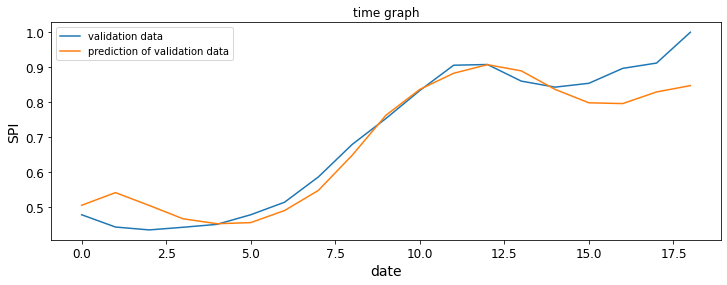

In [41]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()

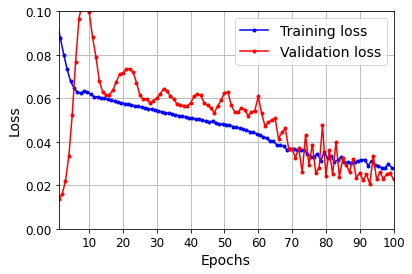

In [42]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Simple RNN

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[12, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train_t, y_train, epochs=100,
                    validation_data=(X_valid_t, y_valid))

Epoch 1/100
3/3 [==============================] - 0s 31ms/step - loss: 0.0954 - val_loss: 0.0137
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0876 - val_loss: 0.0158
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0801 - val_loss: 0.0219
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0733 - val_loss: 0.0336
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0679 - val_loss: 0.0524
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0649 - val_loss: 0.0769
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0627 - val_loss: 0.0966
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0624 - val_loss: 0.1047
Epoch 9/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0633 - val_loss: 0.1080
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0628 - val_loss: 0.0998
Epoch 11/100
3/3 [==========

In [44]:
y_pred = model.predict(X_valid_t)
print(y_pred)

[[0.28903314]
 [0.37504336]
 [0.41853884]
 [0.4462655 ]
 [0.4690284 ]
 [0.48777977]
 [0.5098042 ]
 [0.5355564 ]
 [0.5709879 ]
 [0.6100339 ]
 [0.64273274]
 [0.66872793]
 [0.6874949 ]
 [0.6979126 ]
 [0.7035794 ]
 [0.7077867 ]
 [0.7120317 ]
 [0.7176059 ]
 [0.72319597]]


In [45]:
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(y_valid)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']
print(df_y_pred)
print(df_y_valid)

         SPI
0   0.289033
1   0.375043
2   0.418539
3   0.446265
4   0.469028
5   0.487780
6   0.509804
7   0.535556
8   0.570988
9   0.610034
10  0.642733
11  0.668728
12  0.687495
13  0.697913
14  0.703579
15  0.707787
16  0.712032
17  0.717606
18  0.723196
         SPI
0   0.477961
1   0.442837
2   0.434573
3   0.442149
4   0.450413
5   0.477961
6   0.513774
7   0.586088
8   0.679063
9   0.753444
10  0.833333
11  0.905647
12  0.907713
13  0.860193
14  0.842975
15  0.853994
16  0.896694
17  0.911846
18  1.000000


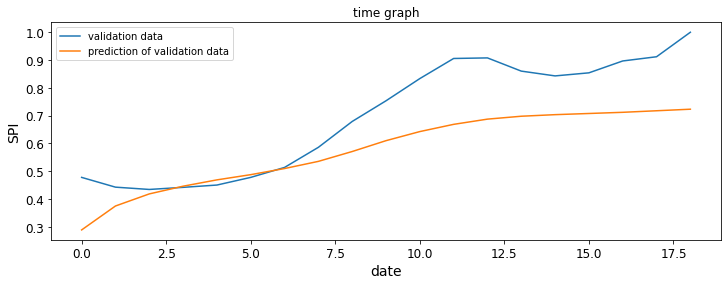

In [46]:
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()

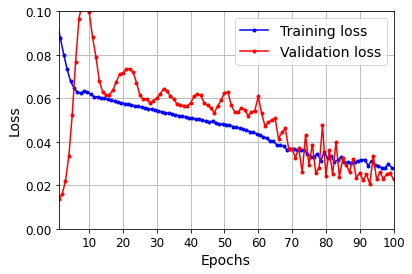

In [47]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 단변량 DeepRNN

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[12, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train_t, y_train, epochs=200,
                    validation_data=(X_valid_t, y_valid))

Epoch 1/200
3/3 [==============================] - 0s 75ms/step - loss: 0.1136 - val_loss: 0.0504
Epoch 2/200
3/3 [==============================] - 0s 9ms/step - loss: 0.1252 - val_loss: 0.0291
Epoch 3/200
3/3 [==============================] - 0s 8ms/step - loss: 0.0916 - val_loss: 0.0351
Epoch 4/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0840 - val_loss: 0.0324
Epoch 5/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0807 - val_loss: 0.0352
Epoch 6/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0660 - val_loss: 0.0574
Epoch 7/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0605 - val_loss: 0.0343
Epoch 8/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0662 - val_loss: 0.0354
Epoch 9/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0615 - val_loss: 0.0484
Epoch 10/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0545 - val_loss: 0.0351
Epoch 11/200
3/3 [==========

3/3 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0077
Epoch 168/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0065
Epoch 169/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0091
Epoch 170/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 171/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0068
Epoch 172/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 173/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0080
Epoch 174/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 175/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0064
Epoch 176/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 177/200
3/3 [=====

[[0.5311611 ]
 [0.5711287 ]
 [0.5393097 ]
 [0.49885243]
 [0.5046249 ]
 [0.5085676 ]
 [0.5304573 ]
 [0.5668244 ]
 [0.6766204 ]
 [0.7524407 ]
 [0.7965532 ]
 [0.83748865]
 [0.8644508 ]
 [0.8600691 ]
 [0.8292603 ]
 [0.80491155]
 [0.7984283 ]
 [0.8063452 ]
 [0.79662645]]
         SPI
0   0.531161
1   0.571129
2   0.539310
3   0.498852
4   0.504625
5   0.508568
6   0.530457
7   0.566824
8   0.676620
9   0.752441
10  0.796553
11  0.837489
12  0.864451
13  0.860069
14  0.829260
15  0.804912
16  0.798428
17  0.806345
18  0.796626
         SPI
0   0.477961
1   0.442837
2   0.434573
3   0.442149
4   0.450413
5   0.477961
6   0.513774
7   0.586088
8   0.679063
9   0.753444
10  0.833333
11  0.905647
12  0.907713
13  0.860193
14  0.842975
15  0.853994
16  0.896694
17  0.911846
18  1.000000


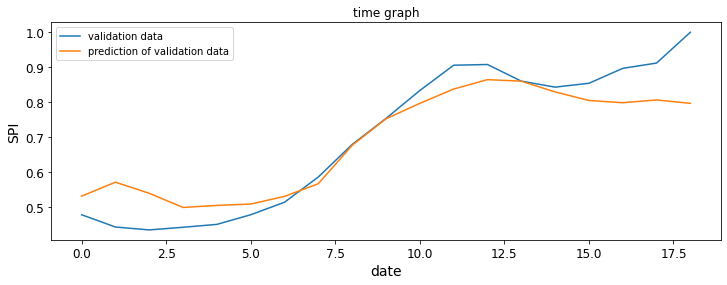

In [49]:
y_pred = model.predict(X_valid_t)
print(y_pred)
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(y_valid)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']
print(df_y_pred)
print(df_y_valid)
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()

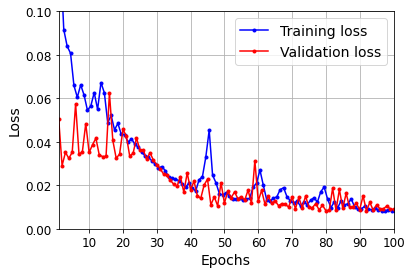

In [50]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## --------------------여기까지 블로그보고 한거-----

## 다변량 RNN LSTM, 과거 한시점으로 현재 한시점 예측

In [41]:
df_apart=pd.read_csv('./data/data_final.csv')

In [42]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [43]:
df_apart=df_apart.iloc[:,1:]
df_time = df_apart['date']
df_time.to_frame()
df_apart = df_apart.set_index('date')

In [44]:
df_apart

,kosave,kosave_quant,kosave_amt,bc,ar,unsoldapt,tr_bond,loan_apt,cd,houseloan_county,...,termdepo,interrate_call,interrate_kb,cpi_jeon,cpi_total,ppi_realestate,ppi_buildlease,cci,cli,SPI
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,1379.25,192731575,2582501187,112303.8,1780.0,697.0,4.97,8.12,4.92,143560.4,...,449295.9,4.63,4.50,75.314,77.573,84.80,89.04,68.2,72.0,75.32
2007-02-01,1434.89,230584554,3353641271,114057.2,2019.1,590.0,4.91,11.67,4.95,144021.6,...,451327.1,4.60,4.50,75.536,77.725,84.88,89.21,68.7,72.3,75.21
2007-03-01,1431.62,276749496,3149139880,117768.3,2492.0,687.0,4.79,7.88,4.94,143788.4,...,452615.8,4.60,4.50,75.683,77.878,85.04,89.39,69.5,72.5,75.92
2007-04-01,1517.12,373783291,4472297898,116494.6,2590.4,685.0,4.94,9.63,4.95,144060.0,...,456907.0,4.69,4.50,75.904,78.031,85.31,89.56,70.3,72.8,75.36
2007-05-01,1614.94,416322121,5060726750,119064.5,2475.5,704.0,5.10,8.22,5.04,143882.3,...,461735.9,4.61,4.50,76.126,78.259,85.40,89.65,70.9,73.1,74.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,1944.24,498673,4662803,216662.0,299.6,205.0,1.16,14792.41,1.49,314138.1,...,1176732.9,1.51,1.50,110.450,106.040,108.50,103.09,112.6,115.7,122.84
2019-09-01,2045.21,453725,4520648,222503.4,293.8,207.0,1.29,17763.43,1.54,315819.7,...,1186785.6,1.52,1.50,110.490,106.060,108.37,103.24,112.5,116.1,124.18
2019-10-01,2065.75,423066,4421096,222908.9,288.0,191.0,1.36,35599.44,1.46,318900.5,...,1201916.8,1.36,1.25,110.560,106.140,108.76,103.28,112.2,116.8,126.02


## train, valid, test 셋 split

In [45]:
train = df_apart.iloc[:97,:]
valid = df_apart.iloc[97:126,:]
test = df_apart.iloc[126:,:]

In [46]:
print(train.head())
print(valid.head())
print(test.head())

             kosave  kosave_quant  kosave_amt        bc      ar  unsoldapt  \
date                                                                         
2007-01-01  1379.25     192731575  2582501187  112303.8  1780.0      697.0   
2007-02-01  1434.89     230584554  3353641271  114057.2  2019.1      590.0   
2007-03-01  1431.62     276749496  3149139880  117768.3  2492.0      687.0   
2007-04-01  1517.12     373783291  4472297898  116494.6  2590.4      685.0   
2007-05-01  1614.94     416322121  5060726750  119064.5  2475.5      704.0   

            tr_bond  loan_apt    cd  houseloan_county  ...  termdepo  \
date                                                   ...             
2007-01-01     4.97      8.12  4.92          143560.4  ...  449295.9   
2007-02-01     4.91     11.67  4.95          144021.6  ...  451327.1   
2007-03-01     4.79      7.88  4.94          143788.4  ...  452615.8   
2007-04-01     4.94      9.63  4.95          144060.0  ...  456907.0   
2007-05-01     5.10  

### Data Scaling

In [50]:
from sklearn.preprocessing import MinMaxScaler
# 스케일러 생성
sc = MinMaxScaler()
# train, valid, test 각각 스케일링 
#같이 fit될 경우 추후 모델 학습시에 낙관적으로 나올 수 있으므로
train_sc = sc.fit_transform(train)
valid_sc = sc.transform(valid)
test_sc = sc.transform(test)
#배열로 변환되었으므로 다시 데이터 프레임으로 변환(병합 위해)
train_sc = pd.DataFrame(data = train_sc, columns = train.columns)
valid_sc = pd.DataFrame(data = valid_sc, columns = valid.columns)
test_sc = pd.DataFrame(data = test_sc, columns = test.columns)

In [51]:
#세 데이터셋 pd.concat()으로 병합
scaledf =pd.concat([train_sc,valid_sc,test_sc])

In [52]:
#스케일된 데이터셋을 배열로 변환
scaled = scaledf.values 

In [53]:
# 차원 및 크기 출력
scaled.shape

(156, 23)

In [54]:
# 각 변수 당 t-1과 t시점의 time step을 만들어주는 함수 생성
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [55]:
reframed = series_to_supervised(scaled, 1, 1)
#t-1시점,t시점 데이터를 한 행으로 둔다    

In [56]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t)
1,0.282900,0.255521,0.280392,0.000000,0.439674,0.062677,0.747449,0.001776,0.715385,0.000000,...,0.004642,0.820290,0.769231,0.009679,0.007124,0.005102,0.015582,0.016077,0.011673,0.332920
2,0.334458,0.305791,0.364261,0.019048,0.604992,0.035079,0.732143,0.002630,0.723077,0.006173,...,0.007588,0.820290,0.769231,0.016088,0.014294,0.015306,0.032081,0.041801,0.019455,0.376937
3,0.331428,0.367099,0.342019,0.059364,0.931964,0.060098,0.701531,0.001718,0.720513,0.003052,...,0.017396,0.846377,0.769231,0.025724,0.021465,0.032526,0.047663,0.067524,0.031128,0.342219
4,0.410654,0.495963,0.485925,0.045527,1.000000,0.059582,0.739796,0.002139,0.723077,0.006687,...,0.028433,0.823188,0.769231,0.035403,0.032151,0.038265,0.055912,0.086817,0.042802,0.278983
5,0.501297,0.552456,0.549923,0.073445,0.920556,0.064483,0.780612,0.001800,0.746154,0.004308,...,0.037367,0.802899,0.769231,0.038586,0.035759,0.038265,0.064161,0.093248,0.062257,0.377557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.931754,0.000255,0.000002,1.149127,-0.574708,-0.068094,-0.168367,2.857162,-0.115385,2.236313,...,1.662620,-0.075362,-0.153846,1.531915,1.334161,1.511480,1.287809,1.427653,1.700389,3.285803
152,0.806436,0.000229,0.000027,1.133701,-0.583904,-0.064225,-0.224490,3.559198,-0.164103,2.283020,...,1.685597,-0.072464,-0.153846,1.533659,1.335099,1.503189,1.301558,1.424437,1.715953,3.368878
153,0.899998,0.000170,0.000012,1.197159,-0.587914,-0.063709,-0.191327,4.274090,-0.151282,2.305527,...,1.720180,-0.118841,-0.230769,1.536711,1.338848,1.528061,1.305225,1.414791,1.743191,3.482951
154,0.919031,0.000129,0.000001,1.201565,-0.591924,-0.067836,-0.173469,8.565822,-0.171795,2.346761,...,1.747505,-0.142029,-0.230769,1.539327,1.341660,1.525510,1.304308,1.414791,1.770428,3.627402


In [57]:
reframed.shape

(155, 46)

In [58]:
# 윈도우가 만들어진 데이터 프레임을 또다서 세 데이터셋으로 split
train = reframed.iloc[:97,:]
valid = reframed.iloc[97:126,:]
test = reframed.iloc[126:,:]
#배열로 변환
train_values = train.values
valid_values = valid.values
test_values = test.values

[[0.28289998 0.25552061 0.28039204 ... 0.01607717 0.01167315 0.33292002]
 [0.33445764 0.30579054 0.36426089 ... 0.04180064 0.01945525 0.37693738]
 [0.33142757 0.36709903 0.34201941 ... 0.06752412 0.0311284  0.34221947]
 ...
 [0.82071573 0.41767488 0.50542041 ... 0.99678457 0.9766537  0.58772474]
 [0.80429585 0.42408689 0.42273884 ... 1.         1.         0.61624303]
 [0.78489223 0.         0.         ... 1.         1.0155642  0.65592064]]
[[8.21966678e-01 2.90214648e-05 1.22572012e-05 ... 9.96784566e-01
  1.03891051e+00 7.12337260e-01]
 [8.69799292e-01 8.08903775e-05 7.04046239e-05 ... 1.00321543e+00
  1.05836576e+00 7.56974582e-01]
 [9.57504772e-01 2.66272902e-04 2.36731798e-04 ... 1.00000000e+00
  1.07782101e+00 7.96032238e-01]
 ...
 [1.00653274e+00 8.03206522e-05 2.05329327e-05 ... 1.31511254e+00
  1.44357977e+00 1.48791073e+00]
 [1.13784540e+00 5.83311123e-05 1.95647009e-04 ... 1.32475884e+00
  1.46692607e+00 1.59454433e+00]
 [1.20299672e+00 4.03522266e-05 1.87382697e-04 ... 1.308

In [59]:
#X와 y(t시점의 종속변수(SPI) 나누기
train_X, train_y = train_values[:, :-1], train_values[:, -1]
valid_X, valid_y = valid_values[:, :-1], valid_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]

In [60]:
#LSTM 모델 학습 시 input값이 3차원 배열이 들어가야하므로 3차원 배열로 변환
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_y = train_y.reshape((train_y.shape[0], 1))

valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
valid_y = valid_y.reshape((valid_y.shape[0], 1))

test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_y = test_y.reshape((test_y.shape[0], 1))


In [61]:
#각 배열의 차원 및 크기 출력
print(train_X.shape,valid_X.shape,test_X.shape)
print(train_y.shape,valid_y.shape,test_y.shape)

(97, 1, 45) (29, 1, 45) (29, 1, 45)
(97, 1) (29, 1) (29, 1)


### 모델빌드 (다변량 LSTM (t-1시점으로 t시점 예측))

In [231]:
np.random.seed(120)
tf.random.set_seed(120)

model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='sgd')

In [232]:
# 모델을 훈련시킨 후
history = model.fit(train_X, train_y, epochs=4000, batch_size=30, 
        validation_data=(valid_X, valid_y), verbose=2, shuffle=False)

Epoch 1/4000
4/4 - 0s - loss: 0.4349 - val_loss: 1.8871
Epoch 2/4000
4/4 - 0s - loss: 0.3038 - val_loss: 1.5986
Epoch 3/4000
4/4 - 0s - loss: 0.2166 - val_loss: 1.3793
Epoch 4/4000
4/4 - 0s - loss: 0.1589 - val_loss: 1.2113
Epoch 5/4000
4/4 - 0s - loss: 0.1206 - val_loss: 1.0818
Epoch 6/4000
4/4 - 0s - loss: 0.0953 - val_loss: 0.9815
Epoch 7/4000
4/4 - 0s - loss: 0.0786 - val_loss: 0.9033
Epoch 8/4000
4/4 - 0s - loss: 0.0675 - val_loss: 0.8420
Epoch 9/4000
4/4 - 0s - loss: 0.0602 - val_loss: 0.7938
Epoch 10/4000
4/4 - 0s - loss: 0.0553 - val_loss: 0.7557
Epoch 11/4000
4/4 - 0s - loss: 0.0520 - val_loss: 0.7255
Epoch 12/4000
4/4 - 0s - loss: 0.0498 - val_loss: 0.7015
Epoch 13/4000
4/4 - 0s - loss: 0.0483 - val_loss: 0.6822
Epoch 14/4000
4/4 - 0s - loss: 0.0472 - val_loss: 0.6668
Epoch 15/4000
4/4 - 0s - loss: 0.0465 - val_loss: 0.6545
Epoch 16/4000
4/4 - 0s - loss: 0.0459 - val_loss: 0.6445
Epoch 17/4000
4/4 - 0s - loss: 0.0455 - val_loss: 0.6364
Epoch 18/4000
4/4 - 0s - loss: 0.0451 - 

Epoch 145/4000
4/4 - 0s - loss: 0.0281 - val_loss: 0.4713
Epoch 146/4000
4/4 - 0s - loss: 0.0280 - val_loss: 0.4701
Epoch 147/4000
4/4 - 0s - loss: 0.0279 - val_loss: 0.4688
Epoch 148/4000
4/4 - 0s - loss: 0.0279 - val_loss: 0.4675
Epoch 149/4000
4/4 - 0s - loss: 0.0278 - val_loss: 0.4662
Epoch 150/4000
4/4 - 0s - loss: 0.0277 - val_loss: 0.4649
Epoch 151/4000
4/4 - 0s - loss: 0.0276 - val_loss: 0.4637
Epoch 152/4000
4/4 - 0s - loss: 0.0275 - val_loss: 0.4624
Epoch 153/4000
4/4 - 0s - loss: 0.0274 - val_loss: 0.4611
Epoch 154/4000
4/4 - 0s - loss: 0.0273 - val_loss: 0.4599
Epoch 155/4000
4/4 - 0s - loss: 0.0273 - val_loss: 0.4586
Epoch 156/4000
4/4 - 0s - loss: 0.0272 - val_loss: 0.4573
Epoch 157/4000
4/4 - 0s - loss: 0.0271 - val_loss: 0.4561
Epoch 158/4000
4/4 - 0s - loss: 0.0270 - val_loss: 0.4548
Epoch 159/4000
4/4 - 0s - loss: 0.0269 - val_loss: 0.4536
Epoch 160/4000
4/4 - 0s - loss: 0.0268 - val_loss: 0.4523
Epoch 161/4000
4/4 - 0s - loss: 0.0267 - val_loss: 0.4511
Epoch 162/4000

Epoch 287/4000
4/4 - 0s - loss: 0.0185 - val_loss: 0.3209
Epoch 288/4000
4/4 - 0s - loss: 0.0184 - val_loss: 0.3201
Epoch 289/4000
4/4 - 0s - loss: 0.0184 - val_loss: 0.3193
Epoch 290/4000
4/4 - 0s - loss: 0.0183 - val_loss: 0.3185
Epoch 291/4000
4/4 - 0s - loss: 0.0183 - val_loss: 0.3178
Epoch 292/4000
4/4 - 0s - loss: 0.0182 - val_loss: 0.3170
Epoch 293/4000
4/4 - 0s - loss: 0.0182 - val_loss: 0.3162
Epoch 294/4000
4/4 - 0s - loss: 0.0181 - val_loss: 0.3154
Epoch 295/4000
4/4 - 0s - loss: 0.0181 - val_loss: 0.3146
Epoch 296/4000
4/4 - 0s - loss: 0.0180 - val_loss: 0.3139
Epoch 297/4000
4/4 - 0s - loss: 0.0180 - val_loss: 0.3131
Epoch 298/4000
4/4 - 0s - loss: 0.0179 - val_loss: 0.3123
Epoch 299/4000
4/4 - 0s - loss: 0.0179 - val_loss: 0.3116
Epoch 300/4000
4/4 - 0s - loss: 0.0179 - val_loss: 0.3108
Epoch 301/4000
4/4 - 0s - loss: 0.0178 - val_loss: 0.3101
Epoch 302/4000
4/4 - 0s - loss: 0.0178 - val_loss: 0.3093
Epoch 303/4000
4/4 - 0s - loss: 0.0177 - val_loss: 0.3086
Epoch 304/4000

4/4 - 0s - loss: 0.0133 - val_loss: 0.2393
Epoch 429/4000
4/4 - 0s - loss: 0.0133 - val_loss: 0.2389
Epoch 430/4000
4/4 - 0s - loss: 0.0133 - val_loss: 0.2385
Epoch 431/4000
4/4 - 0s - loss: 0.0133 - val_loss: 0.2382
Epoch 432/4000
4/4 - 0s - loss: 0.0132 - val_loss: 0.2378
Epoch 433/4000
4/4 - 0s - loss: 0.0132 - val_loss: 0.2374
Epoch 434/4000
4/4 - 0s - loss: 0.0132 - val_loss: 0.2370
Epoch 435/4000
4/4 - 0s - loss: 0.0132 - val_loss: 0.2366
Epoch 436/4000
4/4 - 0s - loss: 0.0131 - val_loss: 0.2363
Epoch 437/4000
4/4 - 0s - loss: 0.0131 - val_loss: 0.2359
Epoch 438/4000
4/4 - 0s - loss: 0.0131 - val_loss: 0.2355
Epoch 439/4000
4/4 - 0s - loss: 0.0131 - val_loss: 0.2352
Epoch 440/4000
4/4 - 0s - loss: 0.0130 - val_loss: 0.2348
Epoch 441/4000
4/4 - 0s - loss: 0.0130 - val_loss: 0.2344
Epoch 442/4000
4/4 - 0s - loss: 0.0130 - val_loss: 0.2341
Epoch 443/4000
4/4 - 0s - loss: 0.0130 - val_loss: 0.2337
Epoch 444/4000
4/4 - 0s - loss: 0.0129 - val_loss: 0.2334
Epoch 445/4000
4/4 - 0s - los

Epoch 570/4000
4/4 - 0s - loss: 0.0107 - val_loss: 0.2022
Epoch 571/4000
4/4 - 0s - loss: 0.0107 - val_loss: 0.2021
Epoch 572/4000
4/4 - 0s - loss: 0.0107 - val_loss: 0.2019
Epoch 573/4000
4/4 - 0s - loss: 0.0107 - val_loss: 0.2017
Epoch 574/4000
4/4 - 0s - loss: 0.0106 - val_loss: 0.2016
Epoch 575/4000
4/4 - 0s - loss: 0.0106 - val_loss: 0.2014
Epoch 576/4000
4/4 - 0s - loss: 0.0106 - val_loss: 0.2013
Epoch 577/4000
4/4 - 0s - loss: 0.0106 - val_loss: 0.2011
Epoch 578/4000
4/4 - 0s - loss: 0.0106 - val_loss: 0.2010
Epoch 579/4000
4/4 - 0s - loss: 0.0106 - val_loss: 0.2008
Epoch 580/4000
4/4 - 0s - loss: 0.0106 - val_loss: 0.2007
Epoch 581/4000
4/4 - 0s - loss: 0.0106 - val_loss: 0.2005
Epoch 582/4000
4/4 - 0s - loss: 0.0105 - val_loss: 0.2004
Epoch 583/4000
4/4 - 0s - loss: 0.0105 - val_loss: 0.2002
Epoch 584/4000
4/4 - 0s - loss: 0.0105 - val_loss: 0.2001
Epoch 585/4000
4/4 - 0s - loss: 0.0105 - val_loss: 0.1999
Epoch 586/4000
4/4 - 0s - loss: 0.0105 - val_loss: 0.1998
Epoch 587/4000

Epoch 712/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1872
Epoch 713/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1872
Epoch 714/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1871
Epoch 715/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1870
Epoch 716/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1870
Epoch 717/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1869
Epoch 718/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1868
Epoch 719/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1868
Epoch 720/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1867
Epoch 721/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1866
Epoch 722/4000
4/4 - 0s - loss: 0.0092 - val_loss: 0.1866
Epoch 723/4000
4/4 - 0s - loss: 0.0091 - val_loss: 0.1865
Epoch 724/4000
4/4 - 0s - loss: 0.0091 - val_loss: 0.1865
Epoch 725/4000
4/4 - 0s - loss: 0.0091 - val_loss: 0.1864
Epoch 726/4000
4/4 - 0s - loss: 0.0091 - val_loss: 0.1863
Epoch 727/4000
4/4 - 0s - loss: 0.0091 - val_loss: 0.1863
Epoch 728/4000
4/4 - 0s - loss: 0.0091 - val_loss: 0.1862
Epoch 729/4000

Epoch 854/4000
4/4 - 0s - loss: 0.0083 - val_loss: 0.1806
Epoch 855/4000
4/4 - 0s - loss: 0.0083 - val_loss: 0.1806
Epoch 856/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1805
Epoch 857/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1805
Epoch 858/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1805
Epoch 859/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1804
Epoch 860/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1804
Epoch 861/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1804
Epoch 862/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1803
Epoch 863/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1803
Epoch 864/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1803
Epoch 865/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1802
Epoch 866/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1802
Epoch 867/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1802
Epoch 868/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1801
Epoch 869/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1801
Epoch 870/4000
4/4 - 0s - loss: 0.0082 - val_loss: 0.1801
Epoch 871/4000

Epoch 996/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1760
Epoch 997/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1759
Epoch 998/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1759
Epoch 999/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1759
Epoch 1000/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1758
Epoch 1001/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1758
Epoch 1002/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1758
Epoch 1003/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1757
Epoch 1004/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1757
Epoch 1005/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1757
Epoch 1006/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1756
Epoch 1007/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1756
Epoch 1008/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1756
Epoch 1009/4000
4/4 - 0s - loss: 0.0075 - val_loss: 0.1755
Epoch 1010/4000
4/4 - 0s - loss: 0.0074 - val_loss: 0.1755
Epoch 1011/4000
4/4 - 0s - loss: 0.0074 - val_loss: 0.1755
Epoch 1012/4000
4/4 - 0s - loss: 0.0074 - val_loss: 0.1755
E

Epoch 1135/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1711
Epoch 1136/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1710
Epoch 1137/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1710
Epoch 1138/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1709
Epoch 1139/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1709
Epoch 1140/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1709
Epoch 1141/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1708
Epoch 1142/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1708
Epoch 1143/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1707
Epoch 1144/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1707
Epoch 1145/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1707
Epoch 1146/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1706
Epoch 1147/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1706
Epoch 1148/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1706
Epoch 1149/4000
4/4 - 0s - loss: 0.0069 - val_loss: 0.1705
Epoch 1150/4000
4/4 - 0s - loss: 0.0068 - val_loss: 0.1705
Epoch 1151/4000
4/4 - 0s - loss: 0.0068 - val_loss: 0.17

Epoch 1274/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1653
Epoch 1275/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1652
Epoch 1276/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1652
Epoch 1277/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1651
Epoch 1278/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1651
Epoch 1279/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1650
Epoch 1280/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1650
Epoch 1281/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1650
Epoch 1282/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1649
Epoch 1283/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1649
Epoch 1284/4000
4/4 - 0s - loss: 0.0064 - val_loss: 0.1648
Epoch 1285/4000
4/4 - 0s - loss: 0.0063 - val_loss: 0.1648
Epoch 1286/4000
4/4 - 0s - loss: 0.0063 - val_loss: 0.1647
Epoch 1287/4000
4/4 - 0s - loss: 0.0063 - val_loss: 0.1647
Epoch 1288/4000
4/4 - 0s - loss: 0.0063 - val_loss: 0.1646
Epoch 1289/4000
4/4 - 0s - loss: 0.0063 - val_loss: 0.1646
Epoch 1290/4000
4/4 - 0s - loss: 0.0063 - val_loss: 0.16

Epoch 1413/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1588
Epoch 1414/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1587
Epoch 1415/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1587
Epoch 1416/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1586
Epoch 1417/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1586
Epoch 1418/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1585
Epoch 1419/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1585
Epoch 1420/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1585
Epoch 1421/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1584
Epoch 1422/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1584
Epoch 1423/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1583
Epoch 1424/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1583
Epoch 1425/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1582
Epoch 1426/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1582
Epoch 1427/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1581
Epoch 1428/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.1581
Epoch 1429/4000
4/4 - 0s - loss: 0.0059 - val_loss: 0.15

Epoch 1552/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1520
Epoch 1553/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1519
Epoch 1554/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1519
Epoch 1555/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1518
Epoch 1556/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1518
Epoch 1557/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1517
Epoch 1558/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1517
Epoch 1559/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1516
Epoch 1560/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1516
Epoch 1561/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1515
Epoch 1562/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1515
Epoch 1563/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1514
Epoch 1564/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1514
Epoch 1565/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1513
Epoch 1566/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1513
Epoch 1567/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.1512
Epoch 1568/4000
4/4 - 0s - loss: 0.0055 - val_loss: 0.15

Epoch 1691/4000
4/4 - 0s - loss: 0.0052 - val_loss: 0.1451
Epoch 1692/4000
4/4 - 0s - loss: 0.0052 - val_loss: 0.1450
Epoch 1693/4000
4/4 - 0s - loss: 0.0052 - val_loss: 0.1450
Epoch 1694/4000
4/4 - 0s - loss: 0.0052 - val_loss: 0.1449
Epoch 1695/4000
4/4 - 0s - loss: 0.0052 - val_loss: 0.1449
Epoch 1696/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1448
Epoch 1697/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1448
Epoch 1698/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1447
Epoch 1699/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1447
Epoch 1700/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1446
Epoch 1701/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1446
Epoch 1702/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1445
Epoch 1703/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1445
Epoch 1704/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1444
Epoch 1705/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1444
Epoch 1706/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.1443
Epoch 1707/4000
4/4 - 0s - loss: 0.0051 - val_loss: 0.14

Epoch 1830/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1384
Epoch 1831/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1383
Epoch 1832/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1383
Epoch 1833/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1382
Epoch 1834/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1382
Epoch 1835/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1381
Epoch 1836/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1381
Epoch 1837/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1381
Epoch 1838/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1380
Epoch 1839/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1380
Epoch 1840/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1379
Epoch 1841/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1379
Epoch 1842/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1378
Epoch 1843/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1378
Epoch 1844/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1377
Epoch 1845/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.1377
Epoch 1846/4000
4/4 - 0s - loss: 0.0048 - val_loss: 0.13

Epoch 1969/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1320
Epoch 1970/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1320
Epoch 1971/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1319
Epoch 1972/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1319
Epoch 1973/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1318
Epoch 1974/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1318
Epoch 1975/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1317
Epoch 1976/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1317
Epoch 1977/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1317
Epoch 1978/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1316
Epoch 1979/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1316
Epoch 1980/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1315
Epoch 1981/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1315
Epoch 1982/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1314
Epoch 1983/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1314
Epoch 1984/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.1313
Epoch 1985/4000
4/4 - 0s - loss: 0.0045 - val_loss: 0.13

Epoch 2108/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1260
Epoch 2109/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1260
Epoch 2110/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1260
Epoch 2111/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1259
Epoch 2112/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1259
Epoch 2113/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1258
Epoch 2114/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1258
Epoch 2115/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1258
Epoch 2116/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1257
Epoch 2117/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1257
Epoch 2118/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1256
Epoch 2119/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1256
Epoch 2120/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1256
Epoch 2121/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1255
Epoch 2122/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1255
Epoch 2123/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.1254
Epoch 2124/4000
4/4 - 0s - loss: 0.0043 - val_loss: 0.12

Epoch 2247/4000
4/4 - 0s - loss: 0.0041 - val_loss: 0.1205
Epoch 2248/4000
4/4 - 0s - loss: 0.0041 - val_loss: 0.1205
Epoch 2249/4000
4/4 - 0s - loss: 0.0041 - val_loss: 0.1205
Epoch 2250/4000
4/4 - 0s - loss: 0.0041 - val_loss: 0.1204
Epoch 2251/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1204
Epoch 2252/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1204
Epoch 2253/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1203
Epoch 2254/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1203
Epoch 2255/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1202
Epoch 2256/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1202
Epoch 2257/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1202
Epoch 2258/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1201
Epoch 2259/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1201
Epoch 2260/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1200
Epoch 2261/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1200
Epoch 2262/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.1200
Epoch 2263/4000
4/4 - 0s - loss: 0.0040 - val_loss: 0.11

Epoch 2386/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1155
Epoch 2387/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1155
Epoch 2388/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1154
Epoch 2389/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1154
Epoch 2390/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1154
Epoch 2391/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1153
Epoch 2392/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1153
Epoch 2393/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1153
Epoch 2394/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1152
Epoch 2395/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1152
Epoch 2396/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1152
Epoch 2397/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1151
Epoch 2398/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1151
Epoch 2399/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1151
Epoch 2400/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1150
Epoch 2401/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.1150
Epoch 2402/4000
4/4 - 0s - loss: 0.0038 - val_loss: 0.11

Epoch 2525/4000
4/4 - 0s - loss: 0.0037 - val_loss: 0.1109
Epoch 2526/4000
4/4 - 0s - loss: 0.0037 - val_loss: 0.1109
Epoch 2527/4000
4/4 - 0s - loss: 0.0037 - val_loss: 0.1109
Epoch 2528/4000
4/4 - 0s - loss: 0.0037 - val_loss: 0.1108
Epoch 2529/4000
4/4 - 0s - loss: 0.0037 - val_loss: 0.1108
Epoch 2530/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1108
Epoch 2531/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1107
Epoch 2532/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1107
Epoch 2533/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1107
Epoch 2534/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1106
Epoch 2535/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1106
Epoch 2536/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1106
Epoch 2537/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1106
Epoch 2538/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1105
Epoch 2539/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1105
Epoch 2540/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.1105
Epoch 2541/4000
4/4 - 0s - loss: 0.0036 - val_loss: 0.11

Epoch 2664/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1068
Epoch 2665/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1068
Epoch 2666/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1068
Epoch 2667/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1067
Epoch 2668/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1067
Epoch 2669/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1067
Epoch 2670/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1066
Epoch 2671/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1066
Epoch 2672/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1066
Epoch 2673/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1066
Epoch 2674/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1065
Epoch 2675/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1065
Epoch 2676/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1065
Epoch 2677/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1064
Epoch 2678/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1064
Epoch 2679/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.1064
Epoch 2680/4000
4/4 - 0s - loss: 0.0035 - val_loss: 0.10

Epoch 2803/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1031
Epoch 2804/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1031
Epoch 2805/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1031
Epoch 2806/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1030
Epoch 2807/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1030
Epoch 2808/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1030
Epoch 2809/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1030
Epoch 2810/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1029
Epoch 2811/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1029
Epoch 2812/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1029
Epoch 2813/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1029
Epoch 2814/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1028
Epoch 2815/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1028
Epoch 2816/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1028
Epoch 2817/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1028
Epoch 2818/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.1027
Epoch 2819/4000
4/4 - 0s - loss: 0.0033 - val_loss: 0.10

Epoch 2942/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0998
Epoch 2943/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0998
Epoch 2944/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0998
Epoch 2945/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0997
Epoch 2946/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0997
Epoch 2947/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0997
Epoch 2948/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0997
Epoch 2949/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0997
Epoch 2950/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0996
Epoch 2951/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0996
Epoch 2952/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0996
Epoch 2953/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0996
Epoch 2954/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0995
Epoch 2955/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0995
Epoch 2956/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0995
Epoch 2957/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.0995
Epoch 2958/4000
4/4 - 0s - loss: 0.0032 - val_loss: 0.09

Epoch 3081/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0969
Epoch 3082/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0969
Epoch 3083/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0969
Epoch 3084/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0968
Epoch 3085/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0968
Epoch 3086/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0968
Epoch 3087/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0968
Epoch 3088/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0968
Epoch 3089/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0967
Epoch 3090/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0967
Epoch 3091/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0967
Epoch 3092/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0967
Epoch 3093/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0967
Epoch 3094/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0966
Epoch 3095/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0966
Epoch 3096/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.0966
Epoch 3097/4000
4/4 - 0s - loss: 0.0031 - val_loss: 0.09

Epoch 3220/4000
4/4 - 0s - loss: 0.0030 - val_loss: 0.0943
Epoch 3221/4000
4/4 - 0s - loss: 0.0030 - val_loss: 0.0943
Epoch 3222/4000
4/4 - 0s - loss: 0.0030 - val_loss: 0.0943
Epoch 3223/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0943
Epoch 3224/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0942
Epoch 3225/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0942
Epoch 3226/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0942
Epoch 3227/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0942
Epoch 3228/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0942
Epoch 3229/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0942
Epoch 3230/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0941
Epoch 3231/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0941
Epoch 3232/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0941
Epoch 3233/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0941
Epoch 3234/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0941
Epoch 3235/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.0941
Epoch 3236/4000
4/4 - 0s - loss: 0.0029 - val_loss: 0.09

Epoch 3359/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0921
Epoch 3360/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0920
Epoch 3361/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0920
Epoch 3362/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0920
Epoch 3363/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0920
Epoch 3364/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0920
Epoch 3365/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0920
Epoch 3366/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0920
Epoch 3367/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0919
Epoch 3368/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0919
Epoch 3369/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0919
Epoch 3370/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0919
Epoch 3371/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0919
Epoch 3372/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0919
Epoch 3373/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0918
Epoch 3374/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0918
Epoch 3375/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.09

Epoch 3498/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0901
Epoch 3499/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0901
Epoch 3500/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0901
Epoch 3501/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0901
Epoch 3502/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0900
Epoch 3503/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0900
Epoch 3504/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0900
Epoch 3505/4000
4/4 - 0s - loss: 0.0028 - val_loss: 0.0900
Epoch 3506/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0900
Epoch 3507/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0900
Epoch 3508/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0900
Epoch 3509/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0899
Epoch 3510/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0899
Epoch 3511/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0899
Epoch 3512/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0899
Epoch 3513/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0899
Epoch 3514/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.08

Epoch 3637/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0884
Epoch 3638/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0884
Epoch 3639/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0884
Epoch 3640/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0884
Epoch 3641/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0883
Epoch 3642/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0883
Epoch 3643/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0883
Epoch 3644/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0883
Epoch 3645/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0883
Epoch 3646/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0883
Epoch 3647/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0883
Epoch 3648/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0883
Epoch 3649/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0883
Epoch 3650/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0882
Epoch 3651/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0882
Epoch 3652/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.0882
Epoch 3653/4000
4/4 - 0s - loss: 0.0027 - val_loss: 0.08

Epoch 3776/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3777/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3778/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3779/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3780/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3781/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3782/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3783/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3784/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3785/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0869
Epoch 3786/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0868
Epoch 3787/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0868
Epoch 3788/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0868
Epoch 3789/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0868
Epoch 3790/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0868
Epoch 3791/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.0868
Epoch 3792/4000
4/4 - 0s - loss: 0.0026 - val_loss: 0.08

Epoch 3915/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0857
Epoch 3916/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0857
Epoch 3917/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0857
Epoch 3918/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0857
Epoch 3919/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0857
Epoch 3920/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0857
Epoch 3921/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0857
Epoch 3922/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0857
Epoch 3923/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0857
Epoch 3924/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0856
Epoch 3925/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0856
Epoch 3926/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0856
Epoch 3927/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0856
Epoch 3928/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0856
Epoch 3929/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0856
Epoch 3930/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.0856
Epoch 3931/4000
4/4 - 0s - loss: 0.0025 - val_loss: 0.08

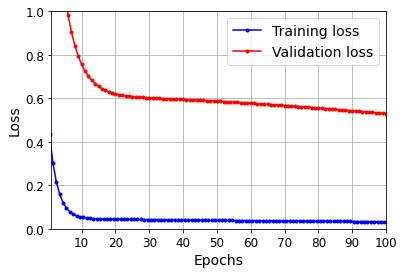

In [233]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

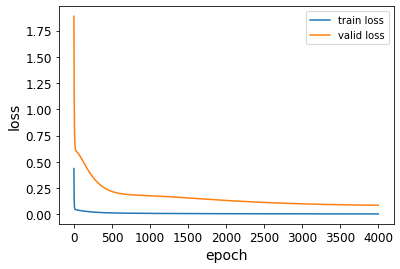

In [237]:
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='valid loss')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

In [238]:
df_time_train=df_time.iloc[:94]
df_time_valid=df_time.iloc[94:125]
df_time_test=df_time.iloc[125:]
df_time_trainval=df_time.iloc[:125]

In [244]:
# df_time_valid.shape
print(df_y_valid.shape)
print(df_y_pred.shape)
# = df_y_pred.set_index(df_time_valid)
# df_y_valid = df_y_valid.set_index(df_time_valid)

# df_y_pred_test = df_y_pred_test.set_index(df_time_test) 
# df_y_test = df_y_test.set_index(df_time_test)

(29, 1)
(29, 1)


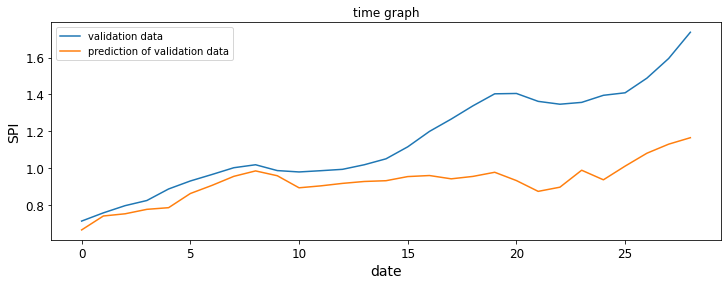

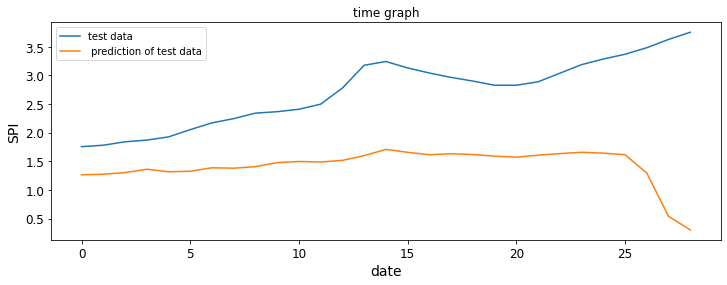

In [235]:
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)

#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']



#valid 시각화
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

#test 시각화
time_plot2 = plt.figure(figsize = (12, 4))
axes2 = time_plot2.add_subplot(1,1,1)    

axes2.plot(df_y_test, label = "test data")
axes2.plot(df_y_pred_test, label = " prediction of test data")

axes2.set_title('time graph')
axes2.set_xlabel('date')

axes2.set_ylabel('SPI')


axes2.legend()

## 단층 퍼셉트론

In [125]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(train_X, train_y, epochs=200,
                    validation_data=(valid_X, valid_y))

Epoch 1/200
4/4 [==============================] - 0s 14ms/step - loss: 0.3664 - val_loss: 0.9274
Epoch 2/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3172 - val_loss: 1.0231
Epoch 3/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2905 - val_loss: 1.0912
Epoch 4/200
4/4 [==============================] - 0s 4ms/step - loss: 0.2698 - val_loss: 1.0793
Epoch 5/200
4/4 [==============================] - 0s 4ms/step - loss: 0.2528 - val_loss: 1.0853
Epoch 6/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2389 - val_loss: 1.0902
Epoch 7/200
4/4 [==============================] - 0s 4ms/step - loss: 0.2265 - val_loss: 1.0707
Epoch 8/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2161 - val_loss: 1.0367
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2075 - val_loss: 0.9899
Epoch 10/200
4/4 [==============================] - 0s 3ms/step - loss: 0.1973 - val_loss: 0.9275
Epoch 11/200
4/4 [==========

4/4 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.1465
Epoch 168/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0211 - val_loss: 0.1603
Epoch 169/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.1666
Epoch 170/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.1579
Epoch 171/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.1451
Epoch 172/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0213 - val_loss: 0.1215
Epoch 173/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0203 - val_loss: 0.1010
Epoch 174/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0203 - val_loss: 0.0849
Epoch 175/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.0784
Epoch 176/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0799
Epoch 177/200
4/4 [=====

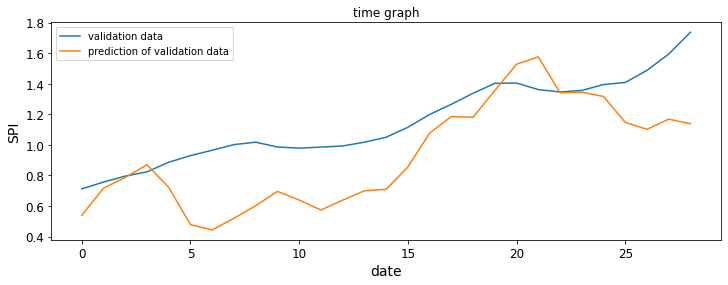

In [131]:
y_pred = model.predict(valid_X)
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()
plt.show()

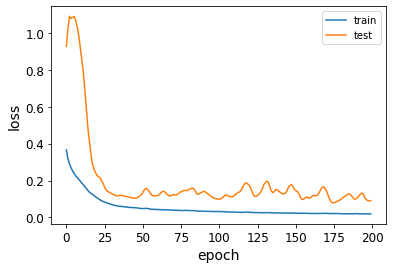

In [133]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.show()

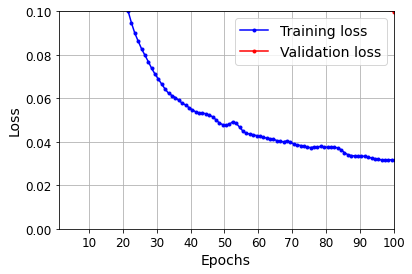

In [132]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Deep RNNs

In [134]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history1 = model.fit(train_X, train_y, epochs=200,
                    validation_data=(valid_X, valid_y))

Epoch 1/200
4/4 [==============================] - 0s 46ms/step - loss: 0.6789 - val_loss: 1.9942
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 0.2315 - val_loss: 1.2361
Epoch 3/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0844 - val_loss: 0.7735
Epoch 4/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0670 - val_loss: 0.5781
Epoch 5/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0748 - val_loss: 0.4834
Epoch 6/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0848 - val_loss: 0.4415
Epoch 7/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0890 - val_loss: 0.4484
Epoch 8/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0882 - val_loss: 0.4824
Epoch 9/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0827 - val_loss: 0.5479
Epoch 10/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0748 - val_loss: 0.6485
Epoch 11/200
4/4 [==========

4/4 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.2010
Epoch 168/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.1772
Epoch 169/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.1687
Epoch 170/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.1811
Epoch 171/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.1914
Epoch 172/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0057 - val_loss: 0.1786
Epoch 173/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.1684
Epoch 174/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.1683
Epoch 175/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.1690
Epoch 176/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.1720
Epoch 177/200
4/4 [=====

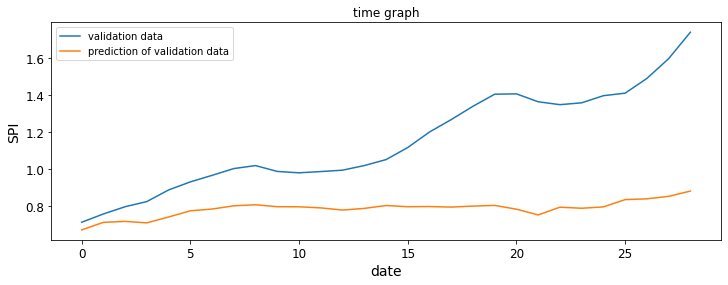

In [136]:
y_pred = model.predict(valid_X)
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()
plt.show()

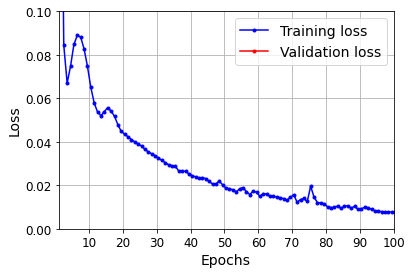

In [137]:
plot_learning_curves(history1.history["loss"], history1.history["val_loss"])
plt.show()

## LSTM 2층 

In [228]:
np.random.seed(42)
tf.random.set_seed(42)


model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=1000,
                    validation_data=(valid_X, valid_y))

Epoch 1/1000
4/4 [==============================] - 0s 103ms/step - loss: 0.5802 - val_loss: 1.0787
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.5109 - val_loss: 0.9938
Epoch 3/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.4389 - val_loss: 0.8894
Epoch 4/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.3529 - val_loss: 0.7492
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2647 - val_loss: 0.5759
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2138 - val_loss: 0.3982
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2090 - val_loss: 0.2915
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2293 - val_loss: 0.2825
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2393 - val_loss: 0.3299
Epoch 10/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2101 - val_loss: 0.4548
Epoch 11/1000
4/4

Epoch 84/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0573 - val_loss: 0.3834
Epoch 85/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0547 - val_loss: 0.3542
Epoch 86/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0546 - val_loss: 0.3823
Epoch 87/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0579 - val_loss: 0.3961
Epoch 88/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0660 - val_loss: 0.3611
Epoch 89/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0580 - val_loss: 0.2825
Epoch 90/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0634 - val_loss: 0.3237
Epoch 91/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0592 - val_loss: 0.3529
Epoch 92/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0599 - val_loss: 0.3058
Epoch 93/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0543 - val_loss: 0.3179
Epoch 94/1

4/4 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.3382
Epoch 167/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0456 - val_loss: 0.3374
Epoch 168/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0448 - val_loss: 0.2970
Epoch 169/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0451 - val_loss: 0.2714
Epoch 170/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0449 - val_loss: 0.2347
Epoch 171/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0453 - val_loss: 0.2548
Epoch 172/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0536 - val_loss: 0.2608
Epoch 173/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0499 - val_loss: 0.2123
Epoch 174/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0445 - val_loss: 0.2599
Epoch 175/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0456 - val_loss: 0.3233
Epoch 176/1000


4/4 [==============================] - 0s 5ms/step - loss: 0.0366 - val_loss: 0.2461
Epoch 249/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0426 - val_loss: 0.2404
Epoch 250/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0491 - val_loss: 0.2746
Epoch 251/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0424 - val_loss: 0.2855
Epoch 252/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0398 - val_loss: 0.1953
Epoch 253/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0376 - val_loss: 0.1569
Epoch 254/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0424 - val_loss: 0.1587
Epoch 255/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0478 - val_loss: 0.1374
Epoch 256/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0443 - val_loss: 0.1875
Epoch 257/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0544 - val_loss: 0.2127
Epoch 258/1000


4/4 [==============================] - 0s 4ms/step - loss: 0.0362 - val_loss: 0.2004
Epoch 331/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0375 - val_loss: 0.2392
Epoch 332/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.2407
Epoch 333/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0403 - val_loss: 0.1445
Epoch 334/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0519 - val_loss: 0.1345
Epoch 335/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0571 - val_loss: 0.2230
Epoch 336/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0384 - val_loss: 0.2924
Epoch 337/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.2540
Epoch 338/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.2407
Epoch 339/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0319 - val_loss: 0.2343
Epoch 340/1000


4/4 [==============================] - 0s 4ms/step - loss: 0.0355 - val_loss: 0.2648
Epoch 413/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0360 - val_loss: 0.2468
Epoch 414/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0364 - val_loss: 0.2265
Epoch 415/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0353 - val_loss: 0.2472
Epoch 416/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0298 - val_loss: 0.2260
Epoch 417/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0304 - val_loss: 0.2259
Epoch 418/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0302 - val_loss: 0.2352
Epoch 419/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0301 - val_loss: 0.2083
Epoch 420/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0363 - val_loss: 0.2001
Epoch 421/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0373 - val_loss: 0.1641
Epoch 422/1000


4/4 [==============================] - 0s 5ms/step - loss: 0.0376 - val_loss: 0.3189
Epoch 495/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0497 - val_loss: 0.3293
Epoch 496/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0432 - val_loss: 0.2437
Epoch 497/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0497 - val_loss: 0.2153
Epoch 498/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0452 - val_loss: 0.3087
Epoch 499/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0337 - val_loss: 0.3205
Epoch 500/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0315 - val_loss: 0.2980
Epoch 501/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0304 - val_loss: 0.3176
Epoch 502/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0374 - val_loss: 0.3142
Epoch 503/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0349 - val_loss: 0.2796
Epoch 504/1000


4/4 [==============================] - 0s 5ms/step - loss: 0.0399 - val_loss: 0.2346
Epoch 577/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0342 - val_loss: 0.2633
Epoch 578/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0338 - val_loss: 0.2128
Epoch 579/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0343 - val_loss: 0.1880
Epoch 580/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0306 - val_loss: 0.2182
Epoch 581/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0291 - val_loss: 0.1979
Epoch 582/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.2041
Epoch 583/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0294 - val_loss: 0.2511
Epoch 584/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.2375
Epoch 585/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0319 - val_loss: 0.2252
Epoch 586/1000


4/4 [==============================] - 0s 5ms/step - loss: 0.0309 - val_loss: 0.2395
Epoch 659/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 0.2569
Epoch 660/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0299 - val_loss: 0.2141
Epoch 661/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0404 - val_loss: 0.2053
Epoch 662/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0320 - val_loss: 0.2463
Epoch 663/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0332 - val_loss: 0.2272
Epoch 664/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0284 - val_loss: 0.2069
Epoch 665/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0291 - val_loss: 0.2167
Epoch 666/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0273 - val_loss: 0.2250
Epoch 667/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0279 - val_loss: 0.2516
Epoch 668/1000


4/4 [==============================] - 0s 5ms/step - loss: 0.0498 - val_loss: 0.2843
Epoch 741/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0398 - val_loss: 0.2278
Epoch 742/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0325 - val_loss: 0.2351
Epoch 743/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0290 - val_loss: 0.2978
Epoch 744/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0384 - val_loss: 0.3138
Epoch 745/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0321 - val_loss: 0.2578
Epoch 746/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0409 - val_loss: 0.2483
Epoch 747/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0314 - val_loss: 0.2929
Epoch 748/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0309 - val_loss: 0.2881
Epoch 749/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0299 - val_loss: 0.2489
Epoch 750/1000


4/4 [==============================] - 0s 5ms/step - loss: 0.0279 - val_loss: 0.2306
Epoch 823/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0281 - val_loss: 0.2421
Epoch 824/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.2247
Epoch 825/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0273 - val_loss: 0.2211
Epoch 826/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0264 - val_loss: 0.2326
Epoch 827/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0272 - val_loss: 0.2157
Epoch 828/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0289 - val_loss: 0.2410
Epoch 829/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0364 - val_loss: 0.2318
Epoch 830/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0306 - val_loss: 0.1866
Epoch 831/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0317 - val_loss: 0.2042
Epoch 832/1000


4/4 [==============================] - 0s 5ms/step - loss: 0.0284 - val_loss: 0.2412
Epoch 905/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.2220
Epoch 906/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0277 - val_loss: 0.2350
Epoch 907/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0289 - val_loss: 0.2202
Epoch 908/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0337 - val_loss: 0.2637
Epoch 909/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0299 - val_loss: 0.2936
Epoch 910/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0320 - val_loss: 0.2180
Epoch 911/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0340 - val_loss: 0.1982
Epoch 912/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0300 - val_loss: 0.2356
Epoch 913/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0303 - val_loss: 0.2076
Epoch 914/1000


4/4 [==============================] - 0s 5ms/step - loss: 0.0265 - val_loss: 0.2458
Epoch 987/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0332 - val_loss: 0.2432
Epoch 988/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0275 - val_loss: 0.1762
Epoch 989/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0465 - val_loss: 0.1715
Epoch 990/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0330 - val_loss: 0.2259
Epoch 991/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0310 - val_loss: 0.2104
Epoch 992/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0292 - val_loss: 0.2029
Epoch 993/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0308 - val_loss: 0.2461
Epoch 994/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0333 - val_loss: 0.2575
Epoch 995/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0272 - val_loss: 0.2328
Epoch 996/1000


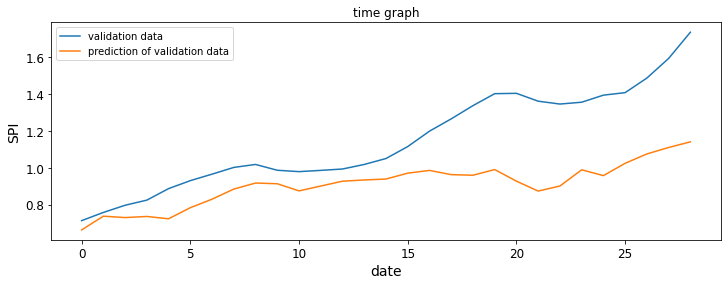

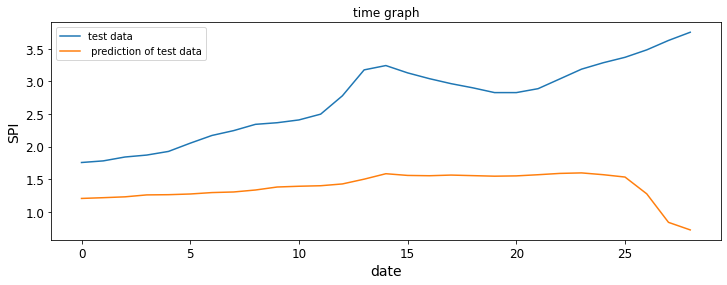

In [229]:
y_pred = model.predict(valid_X)
y_pred_test = model.predict(test_X)

#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)

df_y_pred_test = pd.DataFrame(y_pred_test)
df_y_test = pd.DataFrame(test_y)

df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']

df_y_pred_test.columns=['SPI']
df_y_test.columns=['SPI']



#valid 시각화
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')

axes1.set_ylabel('SPI')


axes1.legend()

#test 시각화
time_plot2 = plt.figure(figsize = (12, 4))
axes2 = time_plot2.add_subplot(1,1,1)    

axes2.plot(df_y_test, label = "test data")
axes2.plot(df_y_pred_test, label = " prediction of test data")

axes2.set_title('time graph')
axes2.set_xlabel('date')

axes2.set_ylabel('SPI')


axes2.legend()

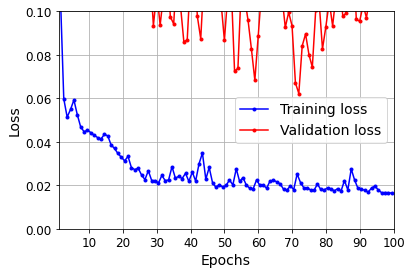

In [125]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 다변량 시계열 RNN, LSTM 기법을 활용하여 t-12~t-1시점 으로 t시점 예측

In [143]:
df_apart.head()

,kosave,kosave_quant,kosave_amt,bc,ar,unsoldapt,tr_bond,loan_apt,cd,houseloan_county,...,termdepo,interrate_call,interrate_kb,cpi_jeon,cpi_total,ppi_realestate,ppi_buildlease,cci,cli,SPI
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,1379.25,192731575,2582501187,112303.8,1780.0,697.0,4.97,8.12,4.92,143560.4,...,449295.9,4.63,4.5,75.314,77.573,84.80,89.04,68.2,72.0,75.32
2007-02-01,1434.89,230584554,3353641271,114057.2,2019.1,590.0,4.91,11.67,4.95,144021.6,...,451327.1,4.60,4.5,75.536,77.725,84.88,89.21,68.7,72.3,75.21
2007-03-01,1431.62,276749496,3149139880,117768.3,2492.0,687.0,4.79,7.88,4.94,143788.4,...,452615.8,4.60,4.5,75.683,77.878,85.04,89.39,69.5,72.5,75.92
2007-04-01,1517.12,373783291,4472297898,116494.6,2590.4,685.0,4.94,9.63,4.95,144060.0,...,456907.0,4.69,4.5,75.904,78.031,85.31,89.56,70.3,72.8,75.36
2007-05-01,1614.94,416322121,5060726750,119064.5,2475.5,704.0,5.10,8.22,5.04,143882.3,...,461735.9,4.61,4.5,76.126,78.259,85.40,89.65,70.9,73.1,74.34


### Data Scaling

In [144]:
#배열로 바꾸기
values = df_apart.values

In [145]:
#minmaxscaler로 모든 값을 0~1사이로로 바꿔준 후

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [146]:
values.shape

(156, 23)

In [147]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [148]:
reframed = series_to_supervised(scaled, 12,1)
#t-12~t데이터를 한 행으로 두며 윈도우를 생성한다. (각 변수의 시점을 t-12부터 t까지) 

In [149]:
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var9(t-12),var10(t-12),...,var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t)
12,0.209173,0.255586,0.280462,0.000000,0.650177,0.155669,0.793750,0.000099,0.763326,0.000000,...,0.045771,0.942356,0.9375,0.054261,0.063906,0.086052,0.183029,0.130719,0.073434,0.144202
13,0.247294,0.305851,0.364323,0.015350,0.753389,0.130809,0.781250,0.000147,0.769723,0.002569,...,0.065538,0.937343,0.9375,0.060538,0.071895,0.086868,0.188640,0.135076,0.069114,0.162868
14,0.245053,0.367154,0.342083,0.047838,0.957524,0.153346,0.756250,0.000096,0.767591,0.001270,...,0.072851,0.937343,0.9375,0.066787,0.079848,0.096656,0.201262,0.137255,0.069114,0.194252
15,0.303633,0.496007,0.485976,0.036688,1.000000,0.152881,0.787500,0.000120,0.769723,0.002783,...,0.078099,0.942356,0.9375,0.075157,0.090522,0.111338,0.213184,0.139434,0.069114,0.224315
16,0.370653,0.552495,0.549967,0.059186,0.950401,0.157296,0.820833,0.000101,0.788913,0.001793,...,0.085348,0.937343,0.9375,0.081406,0.101162,0.118271,0.219495,0.143791,0.071274,0.235877


In [150]:
reframed.shape

(144, 299)

In [151]:
# 훈련, 검증, 테스트 데이터셋으로 나누기

# values = reframed.values
# values
train = reframed.iloc[:97,:]
valid = reframed.iloc[97:126,:]
test = reframed.iloc[126:,:]
print(train.head)
print(valid.head)
print(test.head)
train_values = train.values
valid_values = valid.values
test_values = test.values
# print(train_values)
# print(valid_values)
# print(test_values)

<bound method NDFrame.head of      var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12     0.209173    0.255586    0.280462    0.000000    0.650177    0.155669   
13     0.247294    0.305851    0.364323    0.015350    0.753389    0.130809   
14     0.245053    0.367154    0.342083    0.047838    0.957524    0.153346   
15     0.303633    0.496007    0.485976    0.036688    1.000000    0.152881   
16     0.370653    0.552495    0.549967    0.059186    0.950401    0.157296   
..          ...         ...         ...         ...         ...         ...   
104    0.663734    0.456873    0.460131    0.345469    0.482431    0.411245   
105    0.595282    0.466921    0.484928    0.383573    0.489424    0.394284   
106    0.606827    0.417726    0.505469    0.419090    0.487913    0.347351   
107    0.594686    0.424137    0.422795    0.433615    0.490546    0.308783   
108    0.580339    0.000087    0.000097    0.431215    0.485582    0.341543   

     var7(t-12)  var8

In [152]:
# 훈련, 검증, 테스트 셋 데이터를 x,y로 나누기
train_X, train_y = train_values[:, :-1], train_values[:, -1]
valid_X, valid_y = valid_values[:, :-1], valid_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]

In [153]:
# RNN과 LSTM 학습 시 input값으로 3차원 배열이 필요하므로 3차원으로 변경

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_y = train_y.reshape((train_y.shape[0], 1))

valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
valid_y = valid_y.reshape((valid_y.shape[0], 1))

test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_y = test_y.reshape((test_y.shape[0], 1))


In [154]:
#각 데이터셋의 차원 확인
print(train_X.shape,valid_X.shape,test_X.shape)
print(train_y.shape,valid_y.shape,test_y.shape)

(97, 1, 298) (29, 1, 298) (18, 1, 298)
(97, 1) (29, 1) (18, 1)


### 단층 LSTM 모델빌드 (return_sequences=True)

In [171]:
np.random.seed(50)
tf.random.set_seed(50)

model = Sequential()
model.add(LSTM(30, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 모델을 훈련시킨 후
history = model.fit(train_X, train_y, epochs=100, batch_size=12, 
        validation_data=(valid_X, valid_y), verbose=2, shuffle=False)

Epoch 1/100
9/9 - 0s - loss: 0.1694 - val_loss: 0.6097
Epoch 2/100
9/9 - 0s - loss: 0.0830 - val_loss: 0.2256
Epoch 3/100
9/9 - 0s - loss: 0.0753 - val_loss: 0.1327
Epoch 4/100
9/9 - 0s - loss: 0.1083 - val_loss: 0.1880
Epoch 5/100
9/9 - 0s - loss: 0.0912 - val_loss: 0.1809
Epoch 6/100
9/9 - 0s - loss: 0.0650 - val_loss: 0.2538
Epoch 7/100
9/9 - 0s - loss: 0.0478 - val_loss: 0.1676
Epoch 8/100
9/9 - 0s - loss: 0.0415 - val_loss: 0.1467
Epoch 9/100
9/9 - 0s - loss: 0.0332 - val_loss: 0.1199
Epoch 10/100
9/9 - 0s - loss: 0.0371 - val_loss: 0.1154
Epoch 11/100
9/9 - 0s - loss: 0.0473 - val_loss: 0.0859
Epoch 12/100
9/9 - 0s - loss: 0.0339 - val_loss: 0.1553
Epoch 13/100
9/9 - 0s - loss: 0.0293 - val_loss: 0.1241
Epoch 14/100
9/9 - 0s - loss: 0.0323 - val_loss: 0.1709
Epoch 15/100
9/9 - 0s - loss: 0.0251 - val_loss: 0.1269
Epoch 16/100
9/9 - 0s - loss: 0.0247 - val_loss: 0.1320
Epoch 17/100
9/9 - 0s - loss: 0.0228 - val_loss: 0.1352
Epoch 18/100
9/9 - 0s - loss: 0.0206 - val_loss: 0.1223
E

## 단층 LSTM 모델 빌드(return_sequences = False)

In [180]:
np.random.seed(51)
tf.random.set_seed(51)

model = Sequential()
model.add(LSTM(30,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# 모델을 훈련시킨 후
history = model.fit(train_X, train_y, epochs=100, batch_size=12, 
        validation_data=(valid_X, valid_y), verbose=2, shuffle=False)

Epoch 1/100
9/9 - 0s - loss: 0.2041 - val_loss: 0.3051
Epoch 2/100
9/9 - 0s - loss: 0.0681 - val_loss: 0.1353
Epoch 3/100
9/9 - 0s - loss: 0.0490 - val_loss: 0.1206
Epoch 4/100
9/9 - 0s - loss: 0.1118 - val_loss: 0.1172
Epoch 5/100
9/9 - 0s - loss: 0.0641 - val_loss: 0.1116
Epoch 6/100
9/9 - 0s - loss: 0.0564 - val_loss: 0.1688
Epoch 7/100
9/9 - 0s - loss: 0.0455 - val_loss: 0.1451
Epoch 8/100
9/9 - 0s - loss: 0.0349 - val_loss: 0.1860
Epoch 9/100
9/9 - 0s - loss: 0.0346 - val_loss: 0.1216
Epoch 10/100
9/9 - 0s - loss: 0.0312 - val_loss: 0.1183
Epoch 11/100
9/9 - 0s - loss: 0.0524 - val_loss: 0.1316
Epoch 12/100
9/9 - 0s - loss: 0.0404 - val_loss: 0.1277
Epoch 13/100
9/9 - 0s - loss: 0.0444 - val_loss: 0.1743
Epoch 14/100
9/9 - 0s - loss: 0.0302 - val_loss: 0.1303
Epoch 15/100
9/9 - 0s - loss: 0.0300 - val_loss: 0.1559
Epoch 16/100
9/9 - 0s - loss: 0.0270 - val_loss: 0.1216
Epoch 17/100
9/9 - 0s - loss: 0.0286 - val_loss: 0.1441
Epoch 18/100
9/9 - 0s - loss: 0.0248 - val_loss: 0.1203
E

[[0.2664805 ]
 [0.26901194]
 [0.26812068]
 [0.26844707]
 [0.2723918 ]
 [0.27589974]
 [0.2820562 ]
 [0.29138416]
 [0.29895106]
 [0.30446488]
 [0.3098222 ]
 [0.3098778 ]
 [0.31446904]
 [0.31658858]
 [0.31320763]
 [0.31412765]
 [0.3159901 ]
 [0.31380296]
 [0.31191823]
 [0.31372753]
 [0.3137575 ]
 [0.31243578]
 [0.31217656]
 [0.30821514]
 [0.30823818]
 [0.3068826 ]
 [0.3031192 ]
 [0.302468  ]
 [0.29985145]]
         SPI
0   0.266481
1   0.269012
2   0.268121
3   0.268447
4   0.272392
5   0.275900
6   0.282056
7   0.291384
8   0.298951
9   0.304465
10  0.309822
11  0.309878
12  0.314469
13  0.316589
14  0.313208
15  0.314128
16  0.315990
17  0.313803
18  0.311918
19  0.313728
20  0.313758
21  0.312436
22  0.312177
23  0.308215
24  0.308238
25  0.306883
26  0.303119
27  0.302468
28  0.299851
         SPI
0   0.262636
1   0.264618
2   0.271226
3   0.279815
4   0.297159
5   0.319458
6   0.337298
7   0.356459
8   0.373802
9   0.374298
10  0.362901
11  0.358771
12  0.361414
13  0.371655
14  0.37

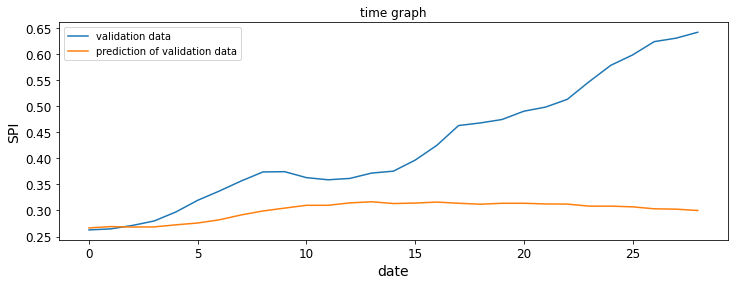

In [174]:
y_pred = model.predict(valid_X)
print(y_pred)
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']
print(df_y_pred)
print(df_y_valid)
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()

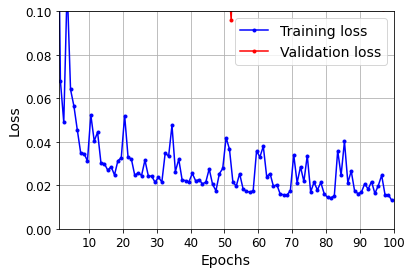

In [175]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 복층 LSTM 모델 빌드

In [185]:
np.random.seed(52)
tf.random.set_seed(52)

model = Sequential()
model.add(LSTM(20, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(30, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(30, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=100, batch_size=20, 
        validation_data=(valid_X, valid_y), verbose=2, shuffle=False)

Epoch 1/100
5/5 - 1s - loss: 0.1528 - val_loss: 0.3902
Epoch 2/100
5/5 - 0s - loss: 0.1077 - val_loss: 0.3389
Epoch 3/100
5/5 - 0s - loss: 0.0719 - val_loss: 0.2889
Epoch 4/100
5/5 - 0s - loss: 0.0594 - val_loss: 0.2541
Epoch 5/100
5/5 - 0s - loss: 0.0567 - val_loss: 0.2387
Epoch 6/100
5/5 - 0s - loss: 0.0568 - val_loss: 0.2379
Epoch 7/100
5/5 - 0s - loss: 0.0552 - val_loss: 0.2455
Epoch 8/100
5/5 - 0s - loss: 0.0535 - val_loss: 0.2546
Epoch 9/100
5/5 - 0s - loss: 0.0526 - val_loss: 0.2618
Epoch 10/100
5/5 - 0s - loss: 0.0526 - val_loss: 0.2649
Epoch 11/100
5/5 - 0s - loss: 0.0527 - val_loss: 0.2651
Epoch 12/100
5/5 - 0s - loss: 0.0526 - val_loss: 0.2634
Epoch 13/100
5/5 - 0s - loss: 0.0524 - val_loss: 0.2610
Epoch 14/100
5/5 - 0s - loss: 0.0521 - val_loss: 0.2585
Epoch 15/100
5/5 - 0s - loss: 0.0519 - val_loss: 0.2572
Epoch 16/100
5/5 - 0s - loss: 0.0516 - val_loss: 0.2571
Epoch 17/100
5/5 - 0s - loss: 0.0514 - val_loss: 0.2578
Epoch 18/100
5/5 - 0s - loss: 0.0512 - val_loss: 0.2583
E

[[0.2749044 ]
 [0.2771937 ]
 [0.27640995]
 [0.2777025 ]
 [0.280741  ]
 [0.28494963]
 [0.289879  ]
 [0.2944345 ]
 [0.30075   ]
 [0.30707744]
 [0.31122866]
 [0.3138439 ]
 [0.31715846]
 [0.31863025]
 [0.3188423 ]
 [0.31945798]
 [0.3206304 ]
 [0.3213479 ]
 [0.3233883 ]
 [0.3247457 ]
 [0.3267469 ]
 [0.32770061]
 [0.3290288 ]
 [0.329803  ]
 [0.3309343 ]
 [0.3310065 ]
 [0.33151636]
 [0.33185592]
 [0.33230293]]
         SPI
0   0.274904
1   0.277194
2   0.276410
3   0.277703
4   0.280741
5   0.284950
6   0.289879
7   0.294434
8   0.300750
9   0.307077
10  0.311229
11  0.313844
12  0.317158
13  0.318630
14  0.318842
15  0.319458
16  0.320630
17  0.321348
18  0.323388
19  0.324746
20  0.326747
21  0.327701
22  0.329029
23  0.329803
24  0.330934
25  0.331006
26  0.331516
27  0.331856
28  0.332303
         SPI
0   0.262636
1   0.264618
2   0.271226
3   0.279815
4   0.297159
5   0.319458
6   0.337298
7   0.356459
8   0.373802
9   0.374298
10  0.362901
11  0.358771
12  0.361414
13  0.371655
14  0.37

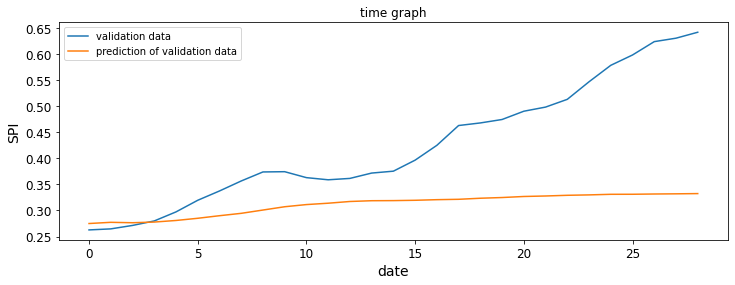

In [186]:
y_pred = model.predict(valid_X)
print(y_pred)
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']
print(df_y_pred)
print(df_y_valid)
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()

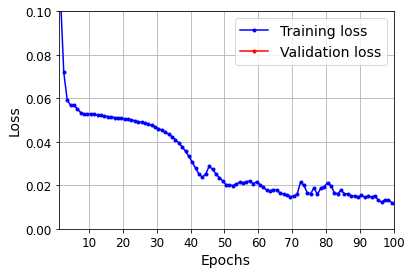

In [187]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 단층 퍼셉트론

In [204]:
np.random.seed(53)
tf.random.set_seed(53)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(train_X, train_y, epochs=100,
                    validation_data=(valid_X, valid_y))

Epoch 1/100
4/4 [==============================] - 0s 16ms/step - loss: 0.5928 - val_loss: 0.1092
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 0.1160 - val_loss: 0.0170
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0277 - val_loss: 0.1472
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0871 - val_loss: 0.1878
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0842 - val_loss: 0.1095
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0379 - val_loss: 0.0366
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0197 - val_loss: 0.0080
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0057
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0316 - val_loss: 0.0104
Epoch 10/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0224 - val_loss: 0.0241
Epoch 11/100
4/4 [==========

[[0.2969093 ]
 [0.33067158]
 [0.30155137]
 [0.291286  ]
 [0.34249896]
 [0.34955898]
 [0.3628733 ]
 [0.4077089 ]
 [0.3822318 ]
 [0.4095995 ]
 [0.4796881 ]
 [0.4907578 ]
 [0.45205688]
 [0.4989107 ]
 [0.5416603 ]
 [0.5756899 ]
 [0.5910803 ]
 [0.6111218 ]
 [0.64361125]
 [0.6823646 ]
 [0.6979354 ]
 [0.714426  ]
 [0.6830092 ]
 [0.67085904]
 [0.7324081 ]
 [0.7249971 ]
 [0.6856697 ]
 [0.73226386]
 [0.73929656]]
         SPI
0   0.296909
1   0.330672
2   0.301551
3   0.291286
4   0.342499
5   0.349559
6   0.362873
7   0.407709
8   0.382232
9   0.409600
10  0.479688
11  0.490758
12  0.452057
13  0.498911
14  0.541660
15  0.575690
16  0.591080
17  0.611122
18  0.643611
19  0.682365
20  0.697935
21  0.714426
22  0.683009
23  0.670859
24  0.732408
25  0.724997
26  0.685670
27  0.732264
28  0.739297
         SPI
0   0.262636
1   0.264618
2   0.271226
3   0.279815
4   0.297159
5   0.319458
6   0.337298
7   0.356459
8   0.373802
9   0.374298
10  0.362901
11  0.358771
12  0.361414
13  0.371655
14  0.37

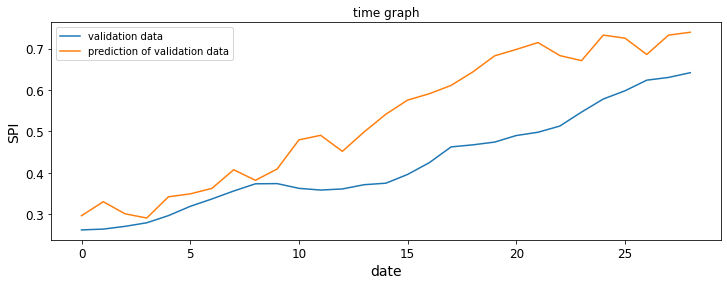

In [205]:
y_pred = model.predict(valid_X)
print(y_pred)
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']
print(df_y_pred)
print(df_y_valid)
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()

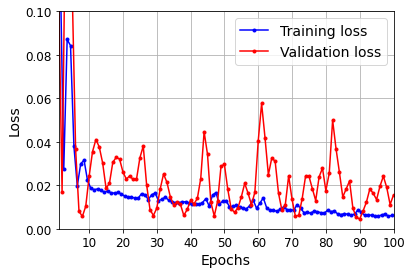

In [206]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## Simple RNN

In [201]:
np.random.seed(54)
tf.random.set_seed(54)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history1 = model.fit(train_X, train_y, epochs=200,
                    validation_data=(valid_X, valid_y))

Epoch 1/200
4/4 [==============================] - 0s 34ms/step - loss: 0.1077 - val_loss: 0.0864
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 0.1609 - val_loss: 0.0128
Epoch 3/200
4/4 [==============================] - 0s 5ms/step - loss: 0.0708 - val_loss: 0.0307
Epoch 4/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0327 - val_loss: 0.0361
Epoch 5/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0166 - val_loss: 0.0691
Epoch 6/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.1213
Epoch 7/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0708
Epoch 8/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0506
Epoch 9/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0465
Epoch 10/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0287
Epoch 11/200
4/4 [==========

Epoch 166/200
4/4 [==============================] - 0s 4ms/step - loss: 5.8054e-04 - val_loss: 0.0231
Epoch 167/200
4/4 [==============================] - 0s 4ms/step - loss: 5.2655e-04 - val_loss: 0.0170
Epoch 168/200
4/4 [==============================] - 0s 4ms/step - loss: 9.3504e-04 - val_loss: 0.0163
Epoch 169/200
4/4 [==============================] - 0s 4ms/step - loss: 5.6949e-04 - val_loss: 0.0225
Epoch 170/200
4/4 [==============================] - 0s 4ms/step - loss: 5.4925e-04 - val_loss: 0.0178
Epoch 171/200
4/4 [==============================] - 0s 4ms/step - loss: 6.3573e-04 - val_loss: 0.0323
Epoch 172/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0254
Epoch 173/200
4/4 [==============================] - 0s 4ms/step - loss: 8.2919e-04 - val_loss: 0.0228
Epoch 174/200
4/4 [==============================] - 0s 4ms/step - loss: 4.5627e-04 - val_loss: 0.0245
Epoch 175/200
4/4 [==============================] - 0s 4ms/step - loss: 8.59

[[0.27029556]
 [0.22781037]
 [0.25194767]
 [0.23825516]
 [0.2281308 ]
 [0.24519567]
 [0.24158016]
 [0.26531953]
 [0.26574555]
 [0.27324882]
 [0.29307082]
 [0.30021846]
 [0.33550322]
 [0.31650358]
 [0.30916336]
 [0.34609488]
 [0.342842  ]
 [0.37875673]
 [0.38092157]
 [0.38475618]
 [0.3766548 ]
 [0.38496953]
 [0.38579017]
 [0.37702   ]
 [0.3773735 ]
 [0.36412072]
 [0.3480651 ]
 [0.3402536 ]
 [0.33487967]]
         SPI
0   0.270296
1   0.227810
2   0.251948
3   0.238255
4   0.228131
5   0.245196
6   0.241580
7   0.265320
8   0.265746
9   0.273249
10  0.293071
11  0.300218
12  0.335503
13  0.316504
14  0.309163
15  0.346095
16  0.342842
17  0.378757
18  0.380922
19  0.384756
20  0.376655
21  0.384970
22  0.385790
23  0.377020
24  0.377373
25  0.364121
26  0.348065
27  0.340254
28  0.334880
         SPI
0   0.262636
1   0.264618
2   0.271226
3   0.279815
4   0.297159
5   0.319458
6   0.337298
7   0.356459
8   0.373802
9   0.374298
10  0.362901
11  0.358771
12  0.361414
13  0.371655
14  0.37

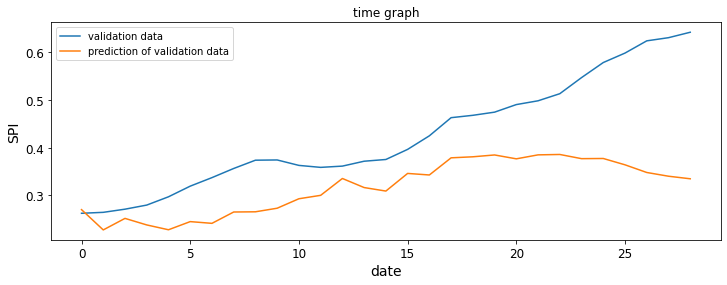

In [202]:
y_pred = model.predict(valid_X)
# print(y_pred)
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']
# print(df_y_pred)
# print(df_y_valid)
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()

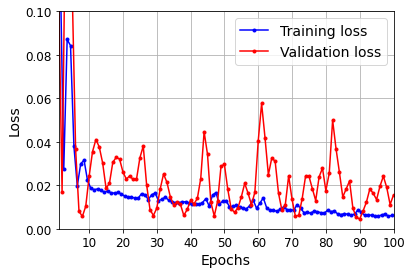

In [203]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Deep RNNs

In [198]:
np.random.seed(54)
tf.random.set_seed(54)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
#     keras.layers.SimpleRNN(20, return_sequences=True),
#     keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history1 = model.fit(train_X, train_y, epochs=200,
                    validation_data=(valid_X, valid_y))

Epoch 1/200
4/4 [==============================] - 0s 61ms/step - loss: 0.0397 - val_loss: 0.0287
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0332 - val_loss: 0.0343
Epoch 3/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0077 - val_loss: 0.0728
Epoch 4/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0737
Epoch 5/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.1007
Epoch 6/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0879
Epoch 7/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0429
Epoch 8/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0390
Epoch 9/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0387
Epoch 10/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0352
Epoch 11/200
4/4 [==========

Epoch 83/200
4/4 [==============================] - 0s 5ms/step - loss: 7.7164e-04 - val_loss: 0.0253
Epoch 84/200
4/4 [==============================] - 0s 4ms/step - loss: 3.9637e-04 - val_loss: 0.0236
Epoch 85/200
4/4 [==============================] - 0s 4ms/step - loss: 4.3196e-04 - val_loss: 0.0246
Epoch 86/200
4/4 [==============================] - 0s 4ms/step - loss: 6.9297e-04 - val_loss: 0.0232
Epoch 87/200
4/4 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0254
Epoch 88/200
4/4 [==============================] - 0s 5ms/step - loss: 9.4104e-04 - val_loss: 0.0191
Epoch 89/200
4/4 [==============================] - 0s 4ms/step - loss: 7.0047e-04 - val_loss: 0.0171
Epoch 90/200
4/4 [==============================] - 0s 4ms/step - loss: 5.9615e-04 - val_loss: 0.0292
Epoch 91/200
4/4 [==============================] - 0s 4ms/step - loss: 4.4574e-04 - val_loss: 0.0312
Epoch 92/200
4/4 [==============================] - 0s 4ms/step - loss: 3.8182e-04 - v

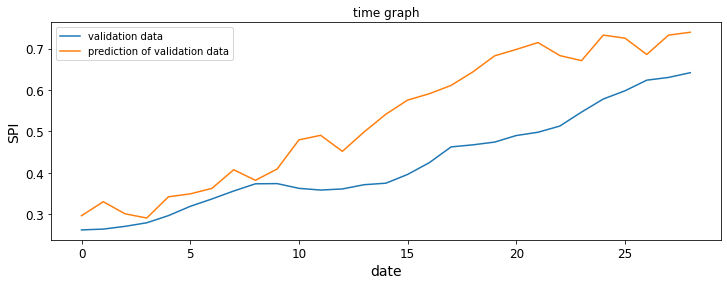

In [208]:
y_pred = model.predict(valid_X)
# print(y_pred)
#훈련 셋
df_y_pred=pd.DataFrame(y_pred)#데이터셋으로 변경
df_y_valid = pd.DataFrame(valid_y)
df_y_pred.columns=['SPI']
df_y_valid.columns=['SPI']
# print(df_y_pred)
# print(df_y_valid)
time_plot2 = plt.figure(figsize = (12, 4))
axes1 = time_plot2.add_subplot(1,1,1)    

axes1.plot(df_y_valid, label = "validation data")
axes1.plot(df_y_pred, label = "prediction of validation data")

axes1.set_title('time graph')
axes1.set_xlabel('date')
axes1.set_ylabel('SPI')
axes1.legend()

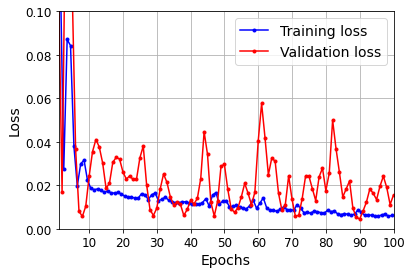

In [200]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 다변량 시계열 LSTM 일정 기간 예측(t-12~ t-1로 t~t11)

In [227]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [228]:
df=pd.read_csv('./data/data_final.csv')
df=df.iloc[:,1:]
df_time = df['date']
df_time.to_frame()
df = df.set_index('date')

In [229]:
TRAIN_SPLIT = 94
VAL_SPLIT = 125
past_history = 12
future_target = 12
STEP = 1

In [230]:
dataset = df.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [231]:
dataset

array([[-1.58058512, -1.71579998, -1.97843866, ..., -1.70602684,
        -1.67054597, -1.0464351 ],
       [-1.36292216, -1.36912329, -1.4046322 , ..., -1.6538004 ,
        -1.62736595, -1.07814247],
       [-1.37571435, -0.94632144, -1.55680198, ..., -1.57023808,
        -1.59857928, -0.87348583],
       ...,
       [ 1.10499403, -3.47705838, -3.89679181, ...,  2.88990035,
         4.7776696 , 13.56777852],
       [ 1.35160569, -3.47625014, -3.8961251 , ...,  2.88990035,
         4.87842297, 14.23939819],
       [ 1.4228821 , -3.47626735, -3.89631231, ...,  2.88990035,
         4.99356967, 14.82454324]])

In [232]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaler = scaler.fit_transform(df)
df_scaler = pd.DataFrame(data = df_scaler, columns = df.columns)

In [233]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_scaler = scaler.fit_transform(df)
df_scaler = pd.DataFrame(data = df_scaler, columns = df.columns)

In [234]:
tf.random.set_seed(14)

In [235]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [236]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 22], 0,
                                                 TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 22],
                                             TRAIN_SPLIT, VAL_SPLIT, past_history, future_target, STEP)
x_test_multi, y_test_multi = multivariate_data(dataset, dataset[:, 22],
                                             VAL_SPLIT, None, past_history, future_target, STEP)

print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (12, 23)

 Target temperature to predict : (12,)


In [237]:
x_val_multi.shape

(19, 12, 23)

In [238]:
x_train_multi.shape

(82, 12, 23)

In [239]:
BATCH_SIZE = 19
BUFFER_SIZE = 20000
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

test_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(BATCH_SIZE).repeat()

In [240]:
train_data_multi

<RepeatDataset shapes: ((None, 12, 23), (None, 12)), types: (tf.float64, tf.float64)>

In [241]:
def create_time_steps(length):
    return list(range(-length, 0))

In [242]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12,12))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:,1]), label="History")
    plt.plot(np.arange(num_out)/STEP, np.array(true_future),'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),'ro',label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

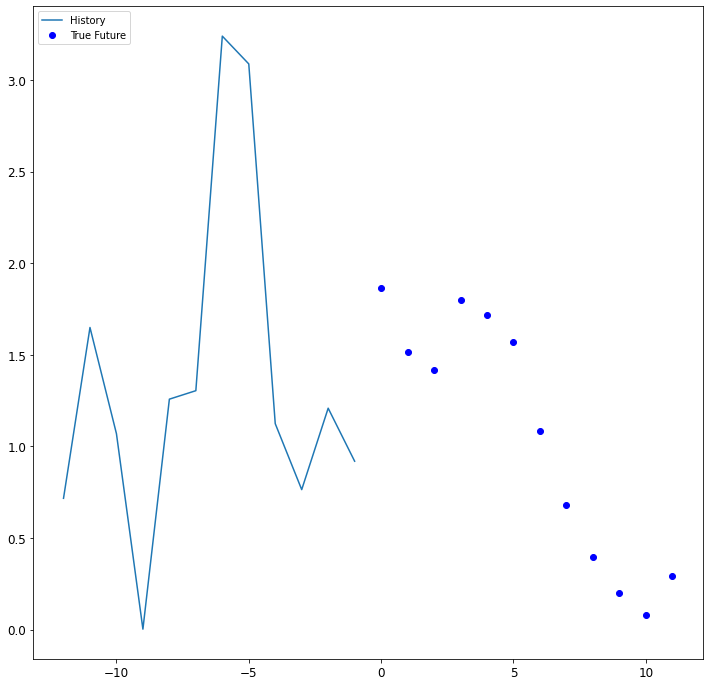

In [244]:
for x,y in train_data_multi.take(1):
    multi_step_plot(x[0],y[0],np.array([0]))

## 단층 LSTM 모델 빌드

In [259]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
multi_step_model = Sequential()
multi_step_model.add(LSTM(30,input_shape = x_train_multi.shape[-2:]))

multi_step_model.add(Dense(12))
multi_step_model.compile(loss='mae', optimizer='adam', metrics = ['accuracy'])

In [260]:
for x,y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(19, 12)


In [261]:
EVALUATION_INTERVAL = 1
EPOCHS = 100
multi_step_history = multi_step_model.fit(train_data_multi, epochs = EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data = val_data_multi,
                                        validation_steps=1)

Epoch 1/100
1/1 [==============================] - 0s 224ms/step - loss: 0.8514 - accuracy: 0.0526 - val_loss: 4.2261 - val_accuracy: 0.0526
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.8992 - accuracy: 0.0000e+00 - val_loss: 4.2277 - val_accuracy: 0.0526
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7377 - accuracy: 0.1053 - val_loss: 4.2311 - val_accuracy: 0.0526
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.8710 - accuracy: 0.1053 - val_loss: 4.2363 - val_accuracy: 0.0526
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0253 - accuracy: 0.0000e+00 - val_loss: 4.2426 - val_accuracy: 0.0526
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.9536 - accuracy: 0.0526 - val_loss: 4.2495 - val_accuracy: 0.0526
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7476 - accuracy: 0.1053 - val_loss: 4.2548 - val_accuracy: 0.0526
Epoch 8/100
1/1 [

In [262]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label="Training loss")
    plt.plot(epochs, val_loss, 'r', label="Validation loss")
    plt.title(title)
    plt.legend()
    
    plt.show()

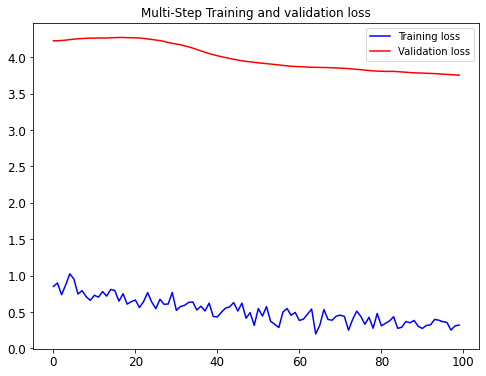

In [263]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

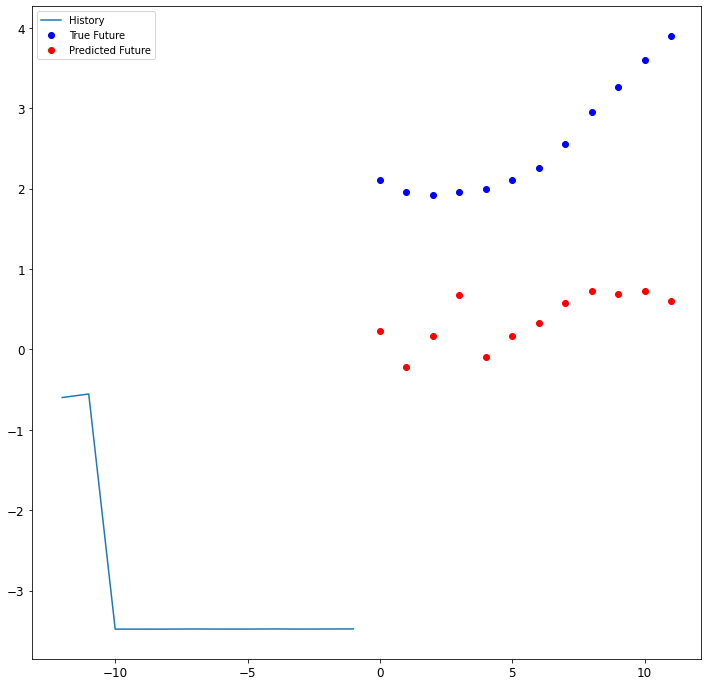

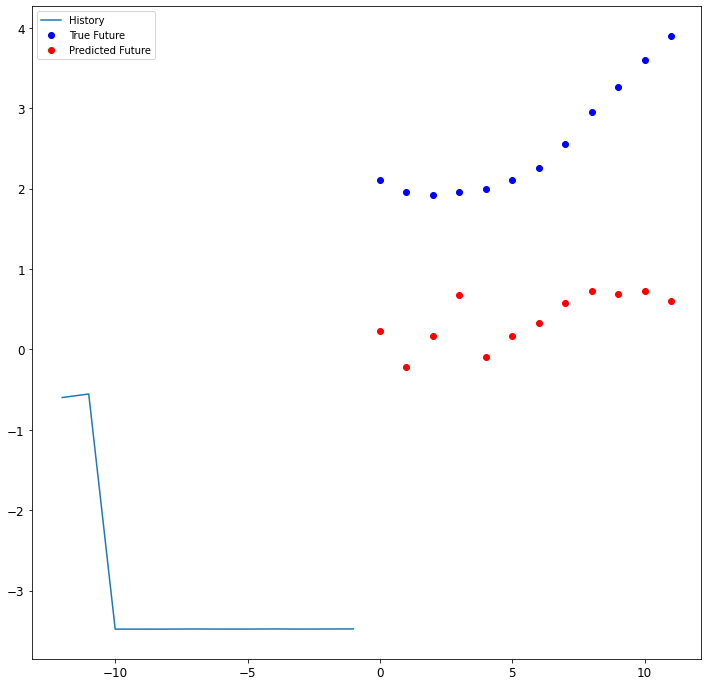

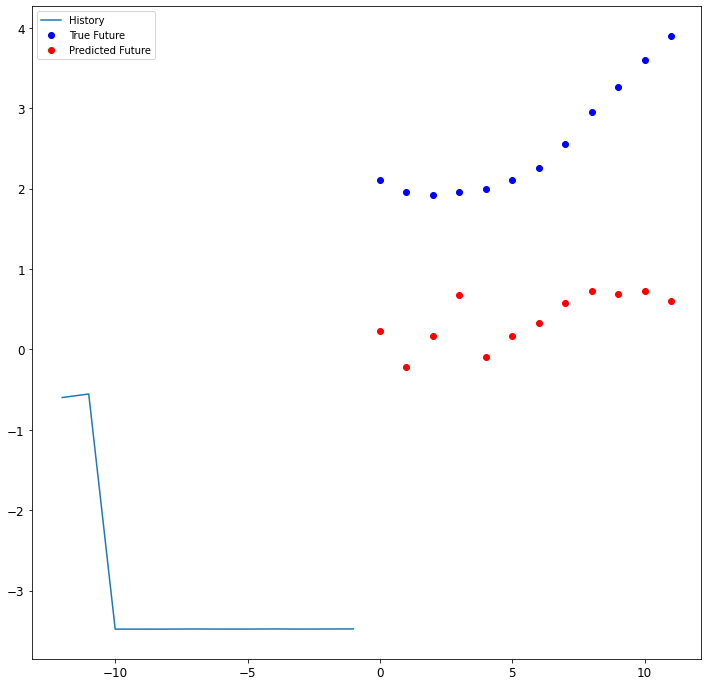

In [264]:
for x, y  in val_data_multi.take(3):
    multi_step_plot(x[0],y[0], multi_step_model.predict(x)[0])

## 다층 LSTM 모델 빌드

In [284]:
multi_step_model = Sequential()
multi_step_model.add(LSTM(30, return_sequences=True,input_shape = x_train_multi.shape[-2:]))
multi_step_model.add(LSTM(30,input_shape = x_train_multi.shape[-2:]))
multi_step_model.add(Dense(12))
multi_step_model.compile(loss='mae', optimizer='adam', metrics = ['accuracy'])

In [285]:
for x,y in val_data_multi.take(1):
    print(multi_step_model.predict(x).shape)

(19, 12)


In [286]:
EVALUATION_INTERVAL = 1
EPOCHS = 100
multi_step_history = multi_step_model.fit(train_data_multi, epochs = EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data = val_data_multi,
                                        validation_steps=1)

Epoch 1/100
1/1 [==============================] - 0s 393ms/step - loss: 0.8276 - accuracy: 0.1053 - val_loss: 4.0224 - val_accuracy: 0.0526
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.8893 - accuracy: 0.0000e+00 - val_loss: 4.0262 - val_accuracy: 0.0526
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.8420 - accuracy: 0.1579 - val_loss: 4.0326 - val_accuracy: 0.0526
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7822 - accuracy: 0.0000e+00 - val_loss: 4.0390 - val_accuracy: 0.0526
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7766 - accuracy: 0.0000e+00 - val_loss: 4.0432 - val_accuracy: 0.0526
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.8322 - accuracy: 0.1053 - val_loss: 4.0467 - val_accuracy: 0.0526
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7060 - accuracy: 0.1053 - val_loss: 4.0500 - val_accuracy: 0.0526
Epoch 8/100
1

In [287]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label="Training loss")
    plt.plot(epochs, val_loss, 'r', label="Validation loss")
    plt.title(title)
    plt.legend()
    
    plt.show()

In [288]:
# multi_step_history.history['val_accuracy']

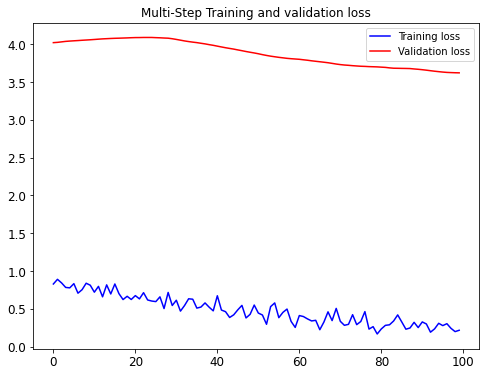

In [289]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## Multi step 예측

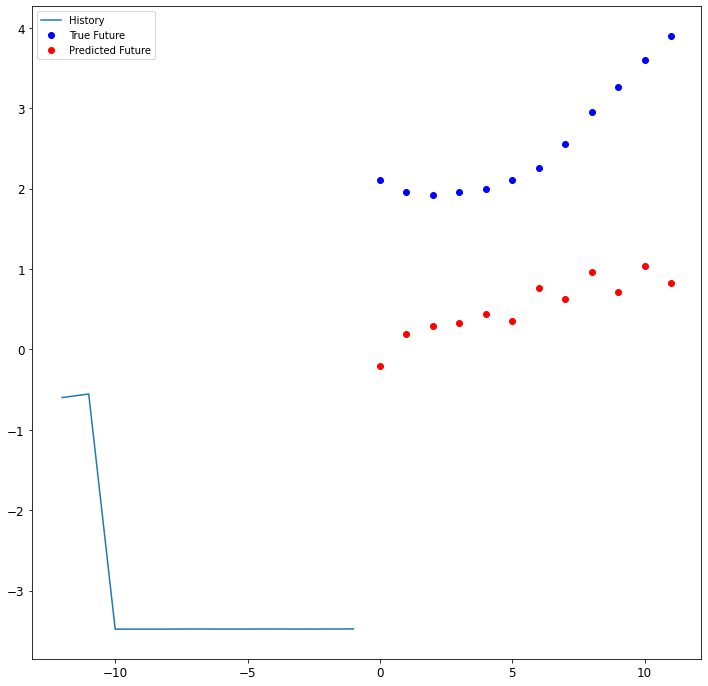

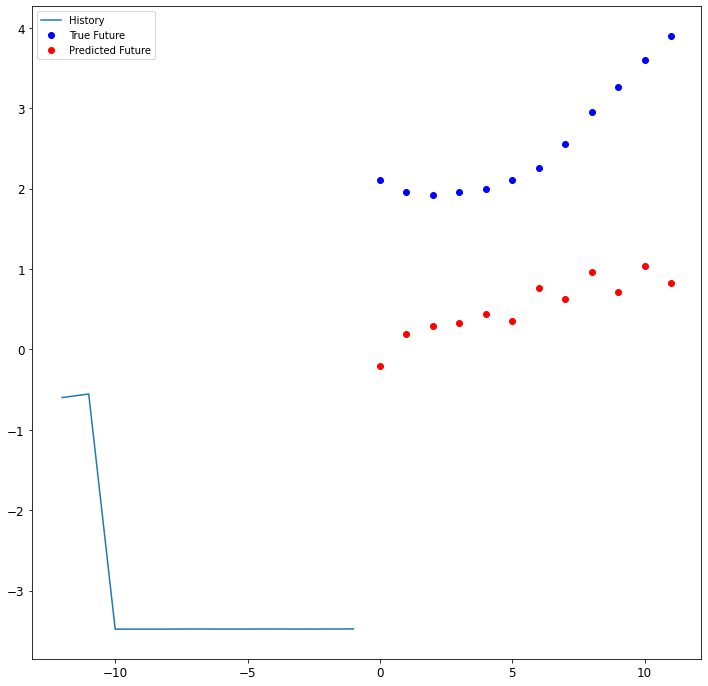

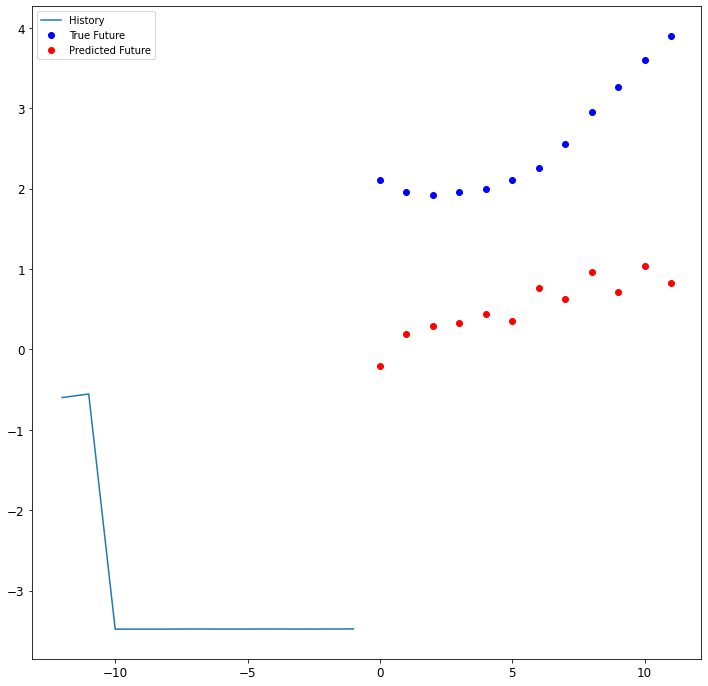

In [290]:
for x, y  in val_data_multi.take(3):
    multi_step_plot(x[0],y[0], multi_step_model.predict(x)[0])

## Simple RNNs

In [297]:
np.random.seed(54)
tf.random.set_seed(54)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True,input_shape = x_train_multi.shape[-2:]),
    keras.layers.SimpleRNN(12)
])

model.compile(loss="mse", optimizer="adam")
history1 = model.fit(x_train_multi,y_train_multi, epochs=200,
                    validation_data=(x_val_multi,y_val_multi))

Epoch 1/200
3/3 [==============================] - 0s 53ms/step - loss: 1.4884 - val_loss: 19.1634
Epoch 2/200
3/3 [==============================] - 0s 8ms/step - loss: 1.4309 - val_loss: 19.1798
Epoch 3/200
3/3 [==============================] - 0s 7ms/step - loss: 1.3813 - val_loss: 19.1959
Epoch 4/200
3/3 [==============================] - 0s 6ms/step - loss: 1.3357 - val_loss: 19.2188
Epoch 5/200
3/3 [==============================] - 0s 6ms/step - loss: 1.2898 - val_loss: 19.2202
Epoch 6/200
3/3 [==============================] - 0s 6ms/step - loss: 1.2502 - val_loss: 19.2294
Epoch 7/200
3/3 [==============================] - 0s 6ms/step - loss: 1.2099 - val_loss: 19.2299
Epoch 8/200
3/3 [==============================] - 0s 6ms/step - loss: 1.1703 - val_loss: 19.2349
Epoch 9/200
3/3 [==============================] - 0s 6ms/step - loss: 1.1311 - val_loss: 19.2389
Epoch 10/200
3/3 [==============================] - 0s 6ms/step - loss: 1.0931 - val_loss: 19.2416
Epoch 11/200
3/3 [

Epoch 84/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2967 - val_loss: 17.9961
Epoch 85/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2934 - val_loss: 17.9884
Epoch 86/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2902 - val_loss: 17.9777
Epoch 87/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2874 - val_loss: 17.9613
Epoch 88/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2845 - val_loss: 17.9374
Epoch 89/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2819 - val_loss: 17.9245
Epoch 90/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2792 - val_loss: 17.9076
Epoch 91/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2768 - val_loss: 17.8863
Epoch 92/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2746 - val_loss: 17.8639
Epoch 93/200
3/3 [==============================] - 0s 6ms/step - loss: 0.2721 - val_loss: 17.8367
Epoch 94/2

3/3 [==============================] - 0s 6ms/step - loss: 0.1752 - val_loss: 15.0752
Epoch 167/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1743 - val_loss: 15.0461
Epoch 168/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1737 - val_loss: 15.0737
Epoch 169/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1728 - val_loss: 15.0586
Epoch 170/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1725 - val_loss: 15.0935
Epoch 171/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1718 - val_loss: 15.0643
Epoch 172/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1711 - val_loss: 15.0865
Epoch 173/200
3/3 [==============================] - 0s 7ms/step - loss: 0.1705 - val_loss: 15.0734
Epoch 174/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1699 - val_loss: 15.0703
Epoch 175/200
3/3 [==============================] - 0s 6ms/step - loss: 0.1693 - val_loss: 15.1145
Epoch 176/200


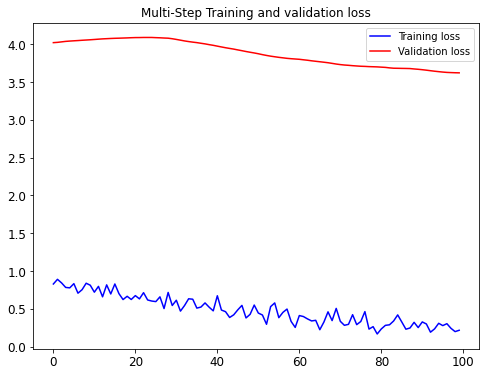

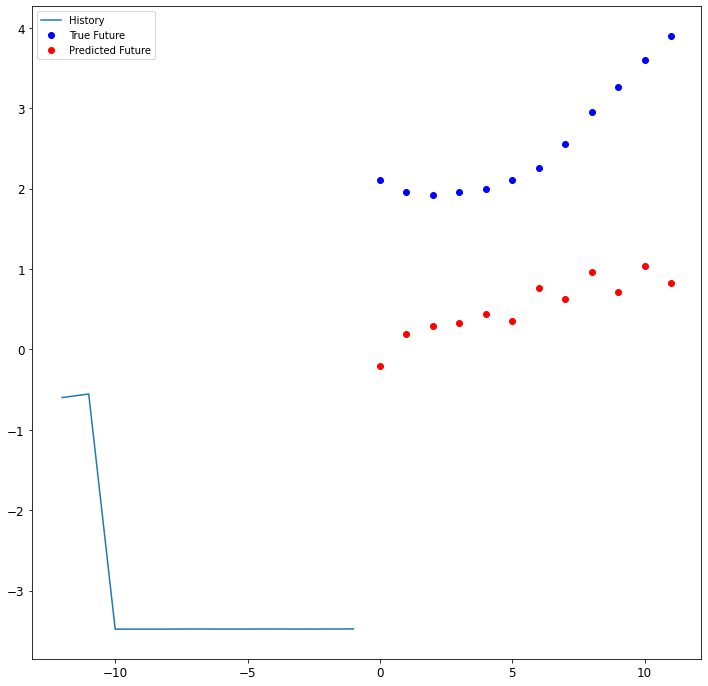

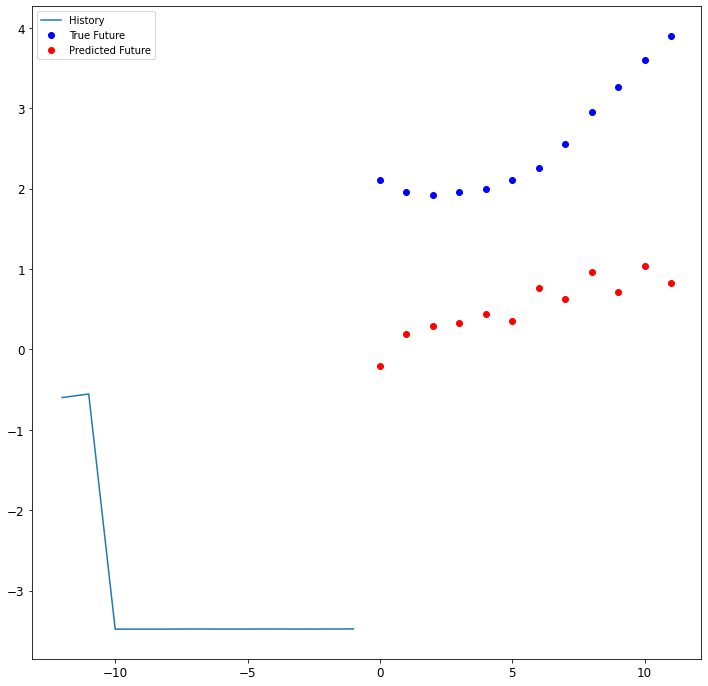

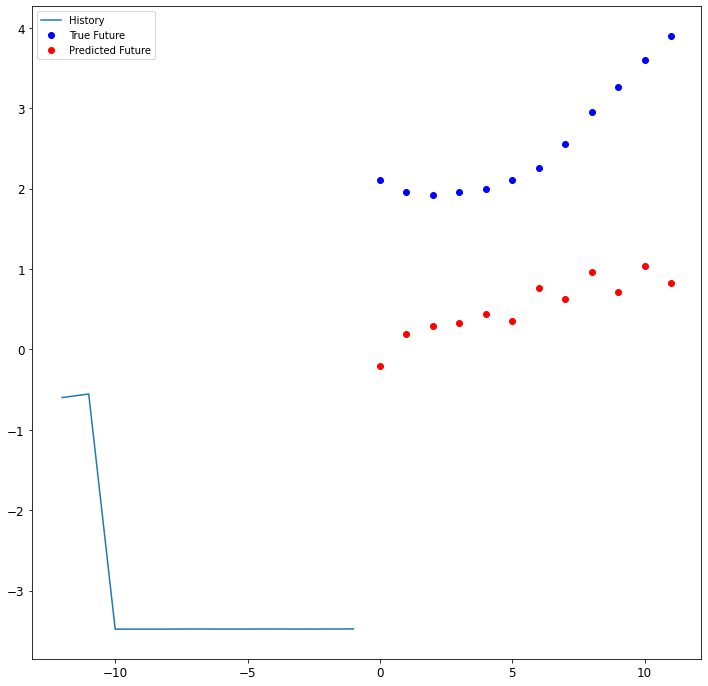

In [299]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')
for x, y  in val_data_multi.take(3):
    multi_step_plot(x[0],y[0], multi_step_model.predict(x)[0])

## Deep Simple RNNs

In [300]:
np.random.seed(54)
tf.random.set_seed(54)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True,input_shape = x_train_multi.shape[-2:]),
    keras.layers.SimpleRNN(20, return_sequences=True,input_shape = x_train_multi.shape[-2:]),
    keras.layers.SimpleRNN(20, return_sequences=True,input_shape = x_train_multi.shape[-2:]),
    keras.layers.SimpleRNN(12)
])

model.compile(loss="mse", optimizer="adam")
history1 = model.fit(x_train_multi,y_train_multi, epochs=200,
                    validation_data=(x_val_multi,y_val_multi))

Epoch 1/200
3/3 [==============================] - 0s 85ms/step - loss: 1.4304 - val_loss: 19.3332
Epoch 2/200
3/3 [==============================] - 0s 12ms/step - loss: 1.2636 - val_loss: 19.6637
Epoch 3/200
3/3 [==============================] - 0s 10ms/step - loss: 1.1232 - val_loss: 20.1351
Epoch 4/200
3/3 [==============================] - 0s 7ms/step - loss: 0.9887 - val_loss: 20.9058
Epoch 5/200
3/3 [==============================] - 0s 8ms/step - loss: 0.8543 - val_loss: 21.6914
Epoch 6/200
3/3 [==============================] - 0s 7ms/step - loss: 0.7739 - val_loss: 22.2625
Epoch 7/200
3/3 [==============================] - 0s 8ms/step - loss: 0.7278 - val_loss: 22.5252
Epoch 8/200
3/3 [==============================] - 0s 8ms/step - loss: 0.6835 - val_loss: 22.6472
Epoch 9/200
3/3 [==============================] - 0s 7ms/step - loss: 0.6410 - val_loss: 22.7060
Epoch 10/200
3/3 [==============================] - 0s 7ms/step - loss: 0.6027 - val_loss: 22.6974
Epoch 11/200
3/3

Epoch 84/200
3/3 [==============================] - 0s 8ms/step - loss: 0.1947 - val_loss: 20.4438
Epoch 85/200
3/3 [==============================] - 0s 8ms/step - loss: 0.1934 - val_loss: 20.5720
Epoch 86/200
3/3 [==============================] - 0s 7ms/step - loss: 0.1927 - val_loss: 20.5343
Epoch 87/200
3/3 [==============================] - 0s 8ms/step - loss: 0.1929 - val_loss: 20.5282
Epoch 88/200
3/3 [==============================] - 0s 7ms/step - loss: 0.1922 - val_loss: 20.6531
Epoch 89/200
3/3 [==============================] - 0s 8ms/step - loss: 0.1927 - val_loss: 20.6765
Epoch 90/200
3/3 [==============================] - 0s 8ms/step - loss: 0.1908 - val_loss: 20.5408
Epoch 91/200
3/3 [==============================] - 0s 8ms/step - loss: 0.1894 - val_loss: 20.6705
Epoch 92/200
3/3 [==============================] - 0s 7ms/step - loss: 0.1883 - val_loss: 20.6589
Epoch 93/200
3/3 [==============================] - 0s 8ms/step - loss: 0.1874 - val_loss: 20.5910
Epoch 94/2

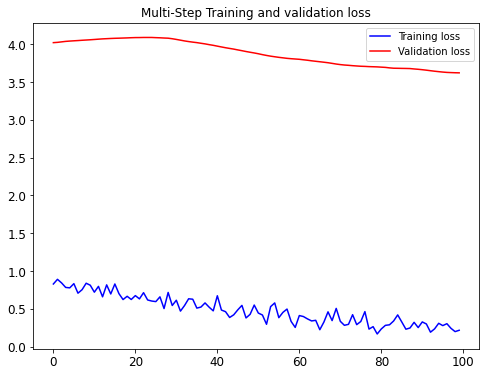

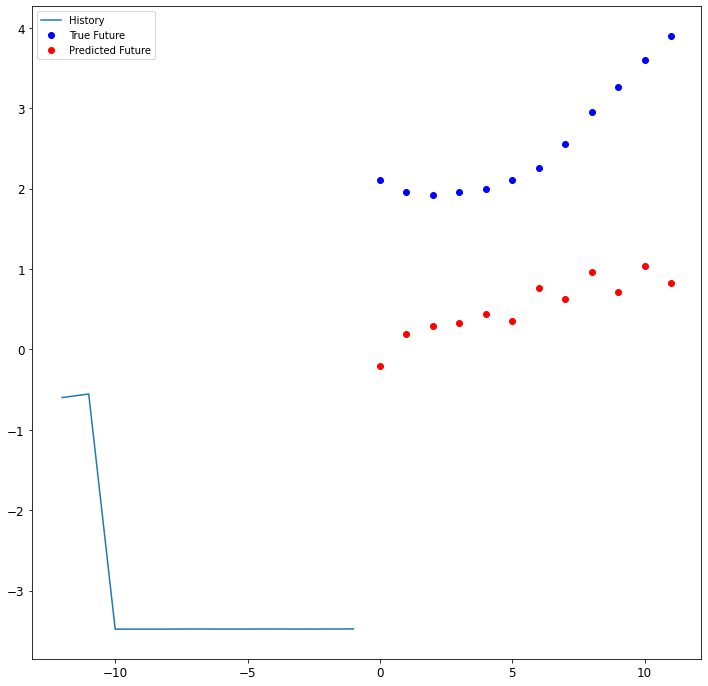

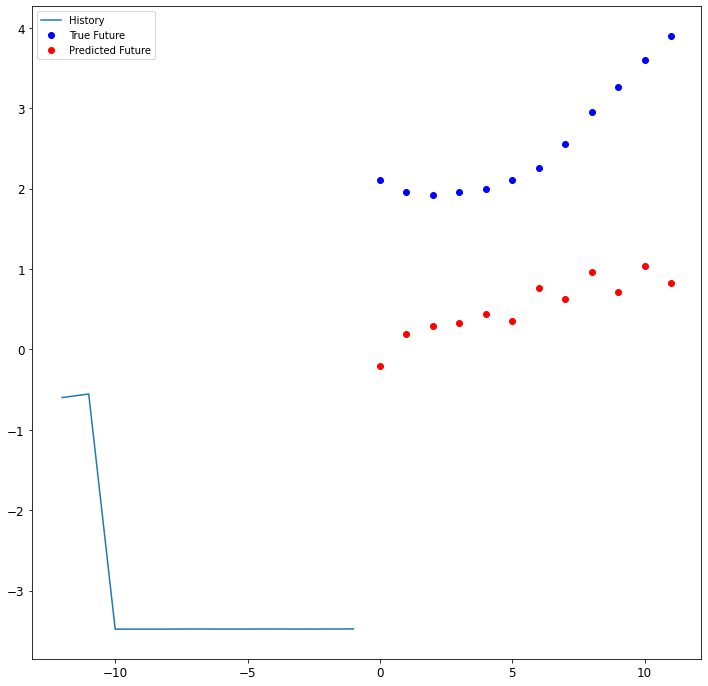

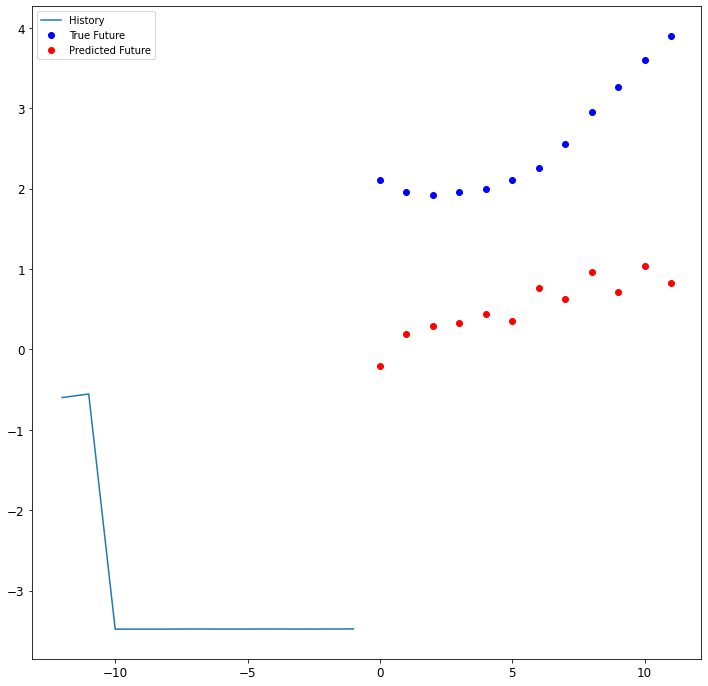

In [301]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')
for x, y  in val_data_multi.take(3):
    multi_step_plot(x[0],y[0], multi_step_model.predict(x)[0])